In [1]:
import os
import skimage.io
from PIL import Image
import cv2
import argparse
import pywt

import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Activation, Concatenate
from keras import Sequential

from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import SGD,Adam
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

#Different Transfer learning rate/models
#https://keras.io/api/applications/
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
#train dataset
df_train = pd.read_excel("gasoline.xlsx", header=None) #trainning data
df_train_label = pd.read_excel("gasoline.xlsx", sheet_name=1, header=None)

In [3]:
#validation dataset
df_regular = pd.read_excel("regular.xlsx", header=None)
df_regular_label = pd.read_excel("regular.xlsx", sheet_name=1, header=None)

df_midgrade = pd.read_excel("midgrade.xlsx", header=None)
df_midgrade_label = pd.read_excel("midgrade.xlsx", sheet_name=1, header=None)

df_premium = pd.read_excel("premium.xlsx", header=None)
df_premium_label = pd.read_excel("premium.xlsx", sheet_name=1, header=None)

#merge all three docs to get validation dataframe
df_validation = df_regular.append(df_midgrade, ignore_index = True)
df_validation = df_validation.append(df_premium, ignore_index = True)


df_validation_label = df_regular_label.append(df_midgrade_label, ignore_index = True)
df_validation_label = df_validation_label.append(df_premium_label, ignore_index = True)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_17416\2880547578.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_validation = df_regular.append(df_midgrade, ignore_index = True)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_17416\2880547578.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_validation = df_validation.append(df_premium, ignore_index = True)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_17416\2880547578.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_validation_label = df_regular_label.append(df_midgrade_label, ignore_index = True)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_17416\2880547578.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [4]:
df_test = pd.read_excel("weathered gasoline.xlsx", header=None)
df_test_label = pd.read_excel("weathered gasoline.xlsx", sheet_name=1, header=None)

In [5]:
#data cleaning
df_train_label = df_train_label.iloc[: , 1:]

df_validation_label = df_validation_label.iloc[: , 0:1]

df_test_label = df_test_label.iloc[: , 0:1]

In [6]:
#check shapes and data of dataframes
print(df_train.shape)
print(df_train_label.shape)

print(df_validation.shape)
print(df_validation_label.shape)

print(df_test.shape)
print(df_test_label.shape)

(345, 1901)
(345, 1)
(45, 1901)
(45, 1)
(60, 1901)
(60, 1)


In [ ]:
#used to create a sample signal
t = np.linspace(0, 1, num=1901)
for row in df_train.itertuples():

    plt.figure(figsize=(15,10))
    plt.plot(t, df_train.iloc[row.Index])

In [ ]:
def create_scalograms(dataframe, dataframe_label, path):
    ids = []
    names = []
  
    for row in dataframe.itertuples():
        coef, freq = pywt.cwt(dataframe.iloc[row.Index], np.arange(1, 1901), 'gaus1')
        signal = abs(coef)

        filepath = path
    
        id = 'image' + str(row.Index)
        name = 'image' + str(row.Index) + '.jpg'

        ids.append(id)
        names.append(name)  

    #type = dataframe_label.iat[row.Index, 0]
    
    
  
    #filepath = path + type.lower() + '/' 
        filepath = path

        plt.ioff()
        plt.figure(figsize=(2.24, 2.24), dpi=200) #the dimension is multplied by the dpi to get display size
        plt.imshow(signal, cmap='inferno')
        plt.axis('off')
        plt.savefig(filepath + name, dpi=100, bbox_inches='tight',pad_inches = 0)
        plt.close()

        filepath = ''

    dataframe_label['Image_id'] = ids
    dataframe_label['Name'] = names

    return dataframe_label
    #plt.show()

In [40]:
def plot_wavelet(signal, path, scales = np.arange(0.25, 512),

                    waveletname = 'morl', #'cmor',

                   cmap = plt.cm.seismic,

                   title = 'Wavelet Transform (Power Spectrum) of signal',

                   ylabel = 'Scales',

                   xlabel = 'Time'):
    
    
    #decode the signal
    
    time = np.arange(len(signal))
    
    dt = time[1] - time[0]

    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)

    power = (abs(coefficients)) ** 2

   

    period = 1. / frequencies

    maxVal = power.max()
    
    n = 8

    levels = [maxVal/(2**(n-i)) for i in range(n)]

    contourlevels = np.log2(levels)

    #print(power.min(), power.max())
    
   

    fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=200)

    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)

   

 

    #ax.set_title(title, fontsize=20)

    #ax.set_ylabel(ylabel, fontsize=18)

    #ax.set_xlabel(xlabel, fontsize=18)

   

   # yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))

    #ax.set_yticks(np.log2(yticks))

    #ax.set_yticklabels(yticks)

    ax.invert_yaxis()

    ylim = ax.get_ylim()

    #ax.set_ylim(ylim[0], -1)

   

    #cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])

    #fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    
    
    plt.ioff()
   
    plt.axis('off')
    ax.axis('off')
    
    plt.savefig(path,  bbox_inches='tight',pad_inches = 0)
    

    #plt.savefig("test.png",  bbox_inches='tight',pad_inches = 0)

 

C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\2054847793.py:42: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


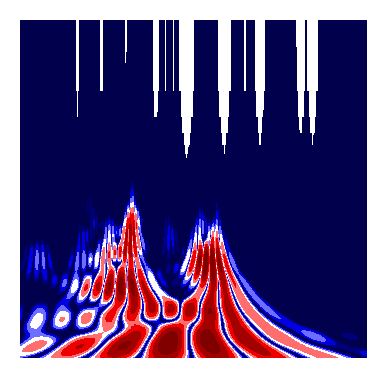

In [37]:
plot_wavelet(df_train.iloc[80], "")

In [38]:
img = Image.open('test.png').convert('RGB')

imgs = np.empty((0, 347, 338, 3)) 

imgs = np.append(imgs, np.array(img).reshape((1, 347, 338, 3)), axis=0)

In [39]:
imgs

array([[[[  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         ...,
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.]],

        [[  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         ...,
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.]],

        [[  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         ...,
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.]],

        ...,

        [[255., 253., 253.],
         [255., 253., 253.],
         [255., 253., 253.],
         ...,
         [  0.,   0.,  77.],
         [  0.,   0.,  77.],
         [  0.,   0.,  77.]],

        [[  0.,   0., 127.],
         [  0.,   0., 127.],
         [  0.,   0., 228.],
         ...,
         [  0.,   0., 228.],
         [  0.,   0., 127.],
         [  0.,   0., 127.]],

        [[  0.,   0., 127.],
       

In [ ]:
train_path = 'scalograms/train/'
validation_path = 'scalograms/validation/'
test_path = 'scalograms/test/'

C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\495793680.py:42: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\495793680.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=200)


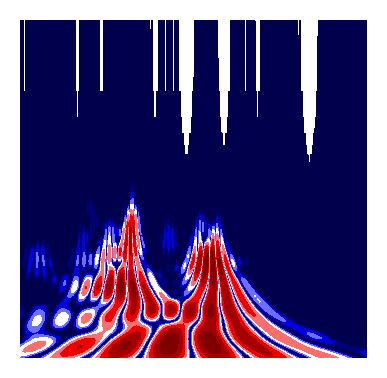

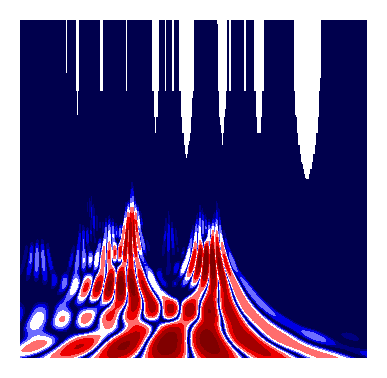

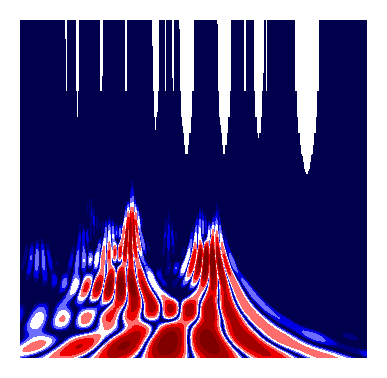

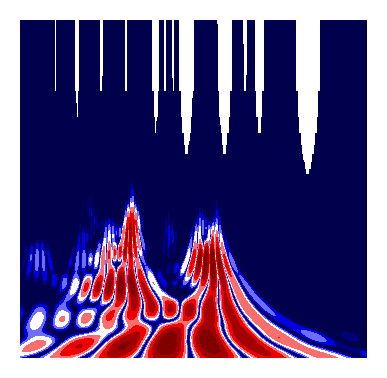

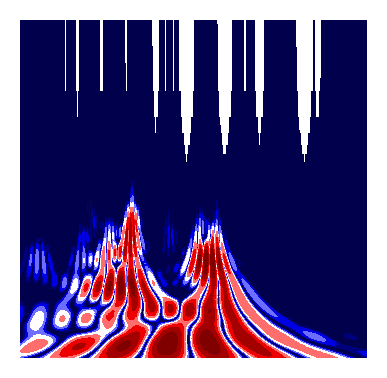

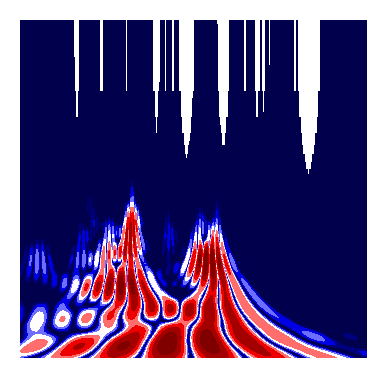

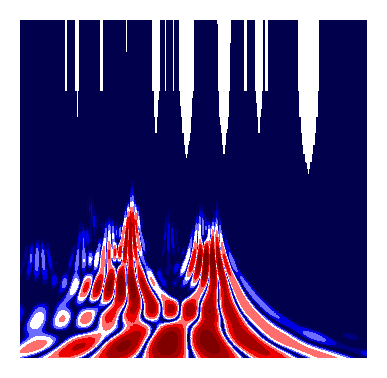

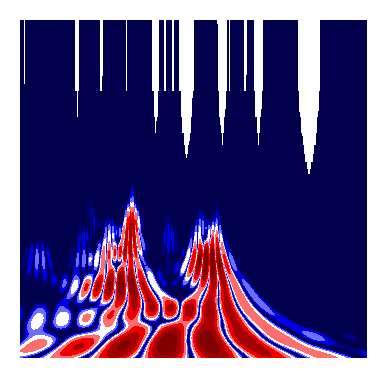

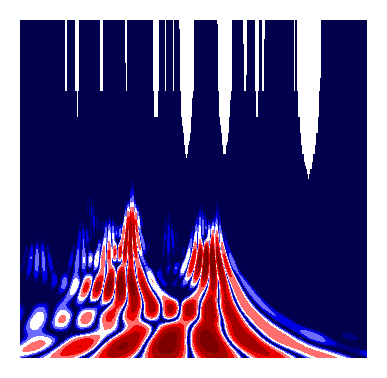

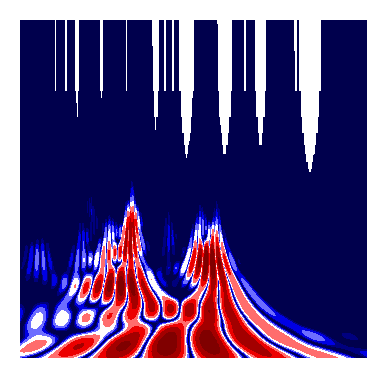

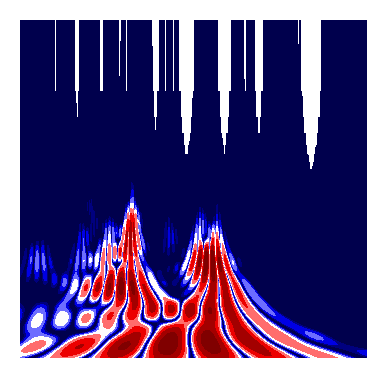

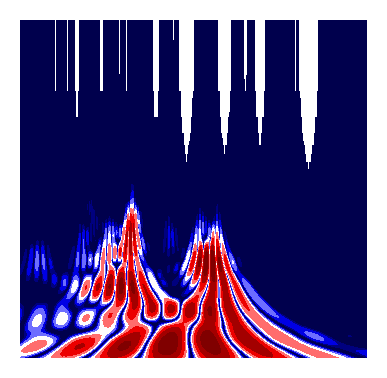

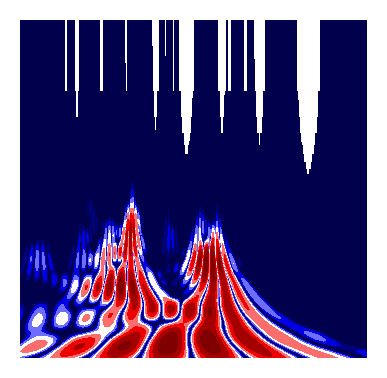

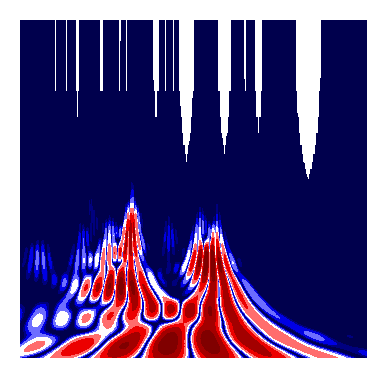

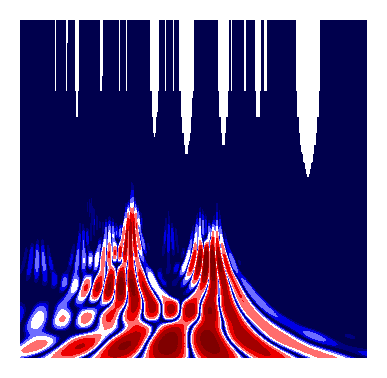

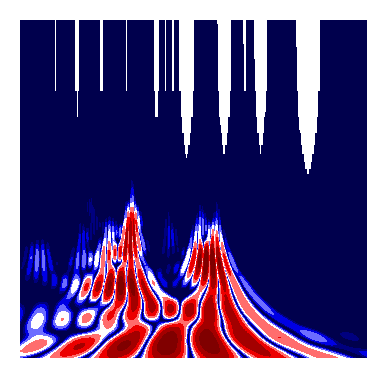

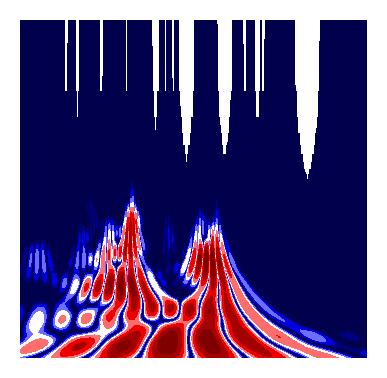

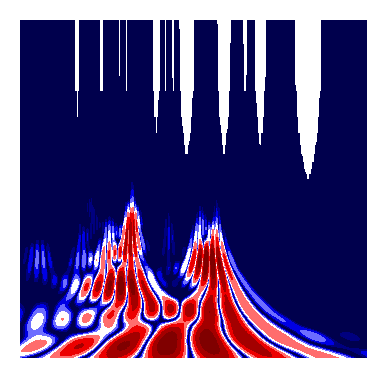

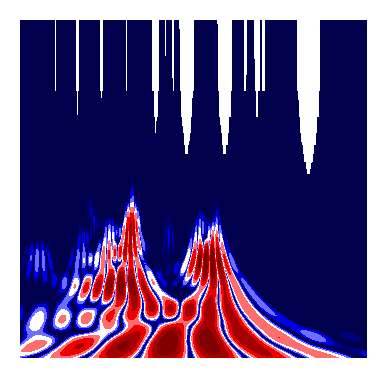

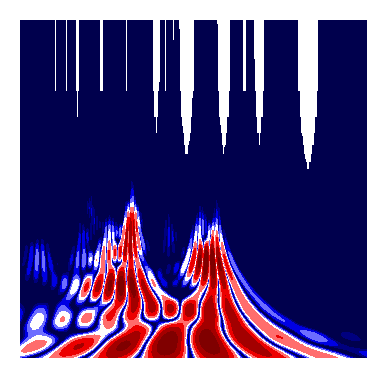

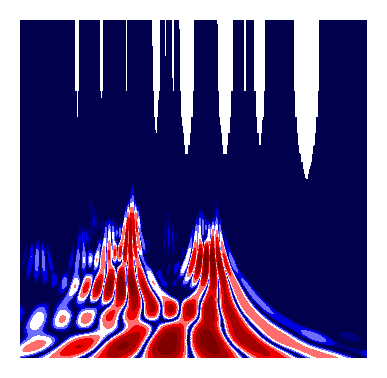

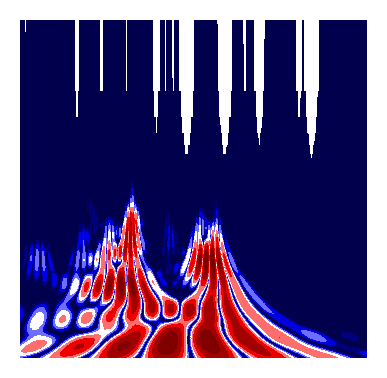

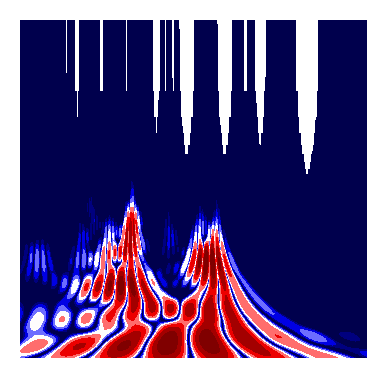

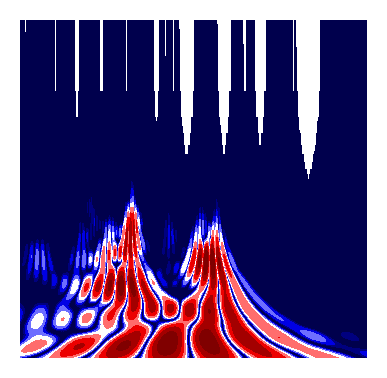

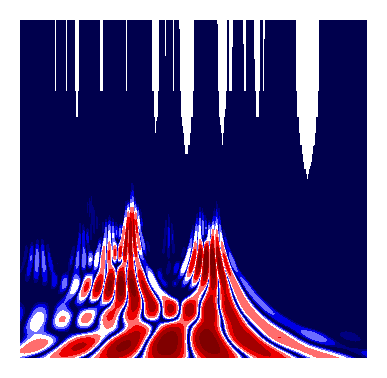

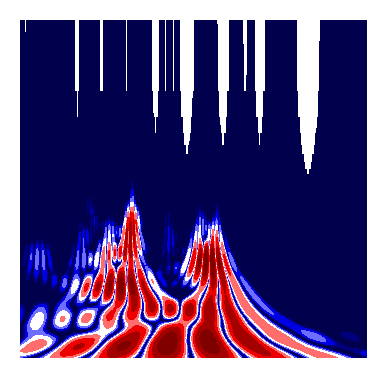

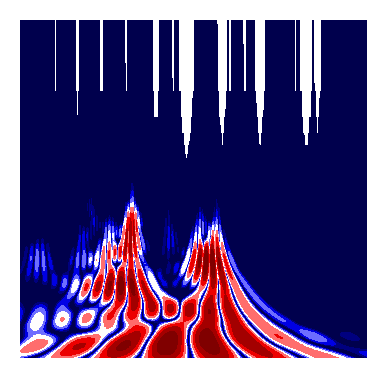

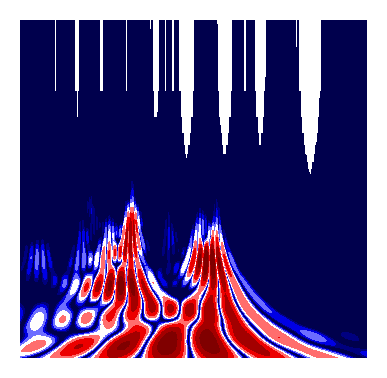

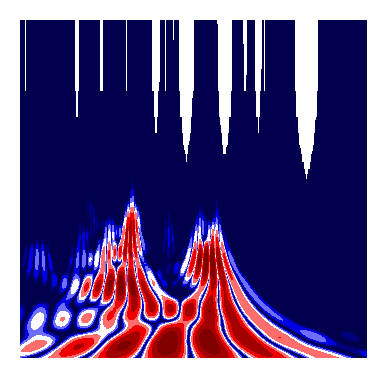

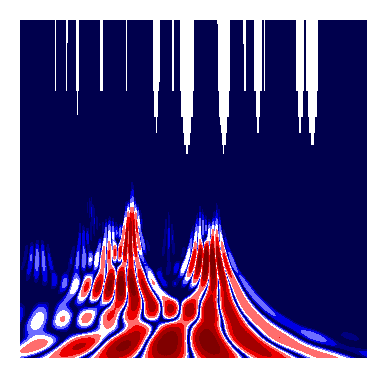

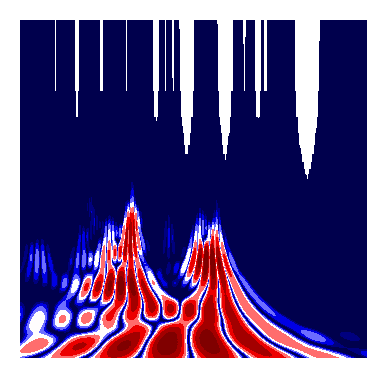

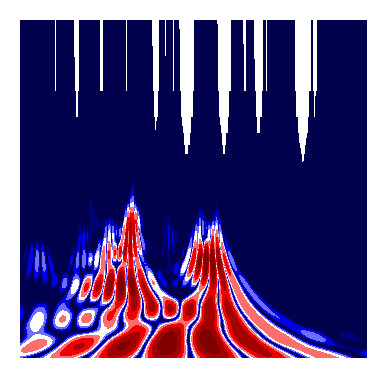

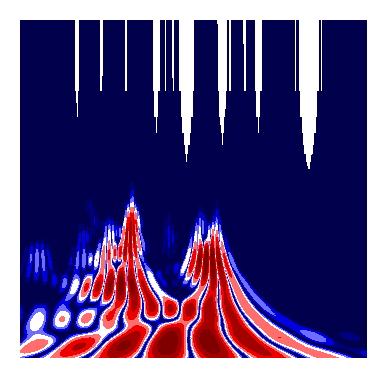

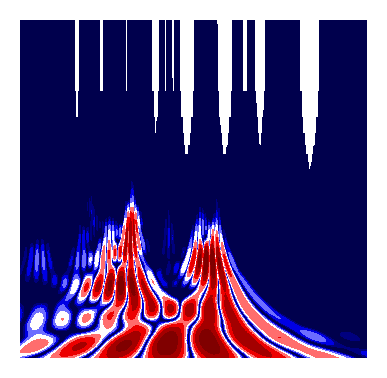

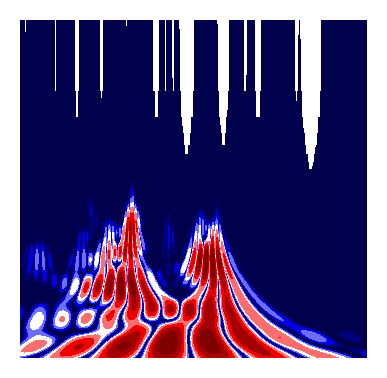

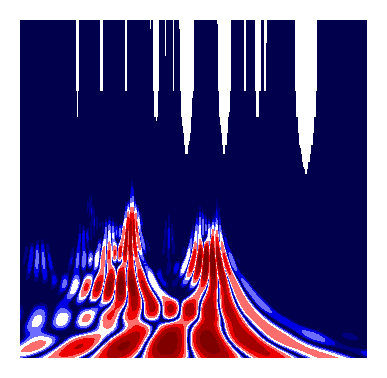

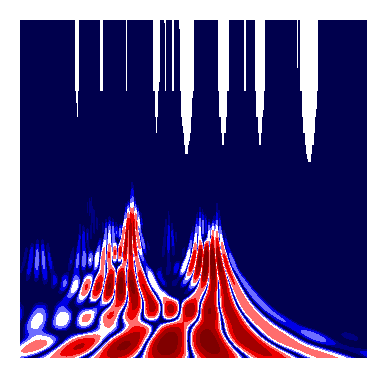

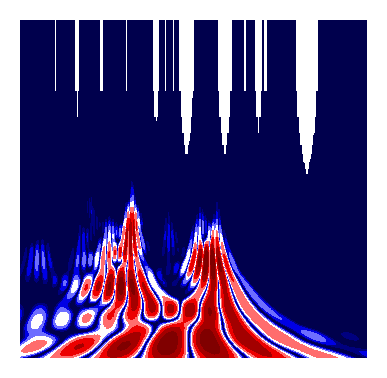

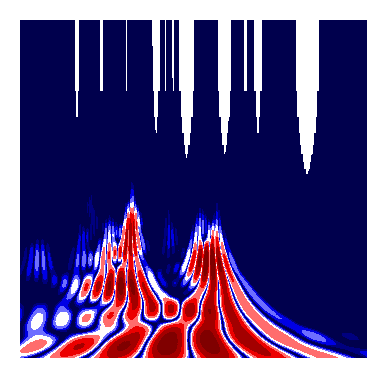

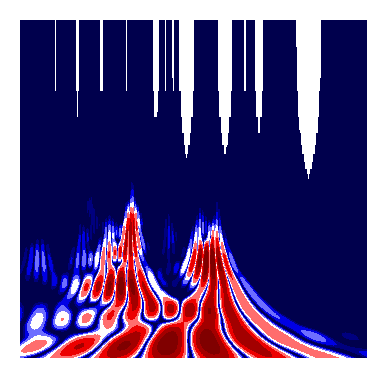

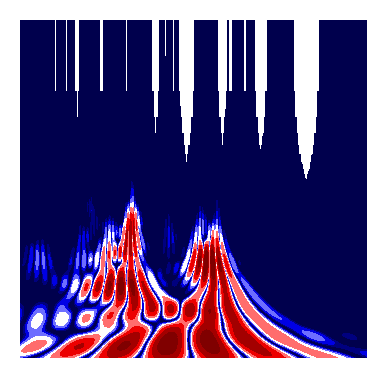

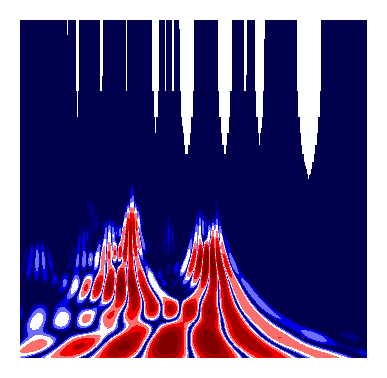

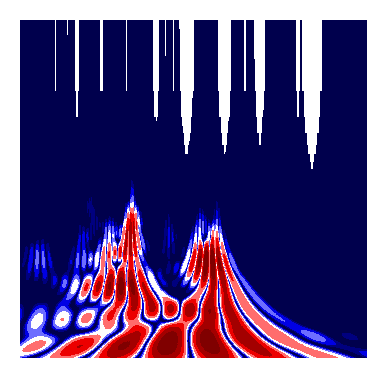

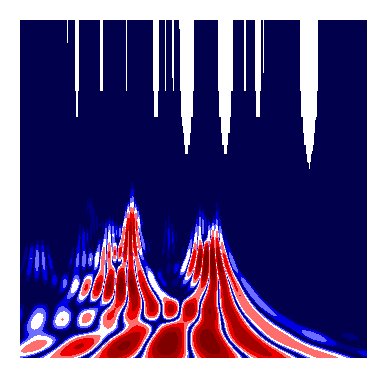

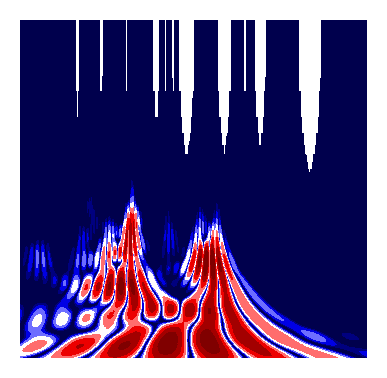

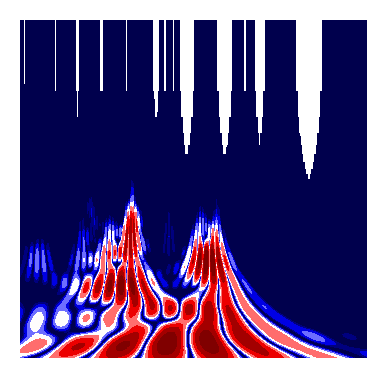

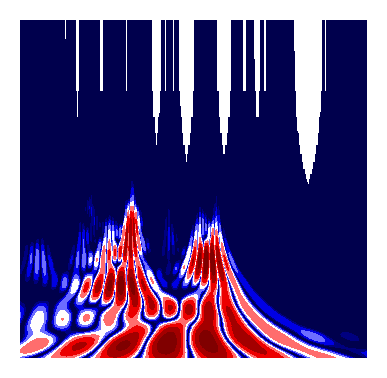

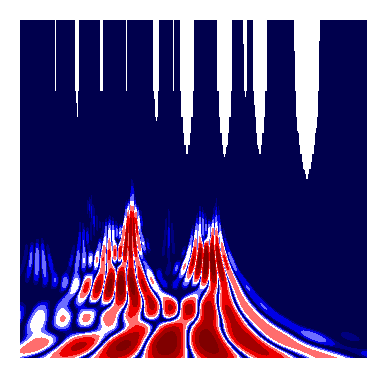

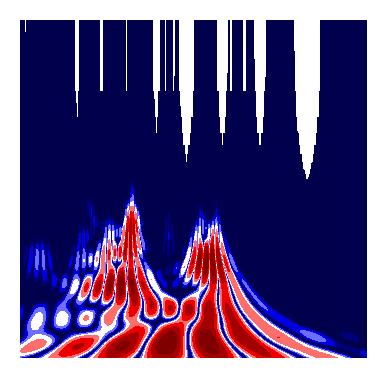

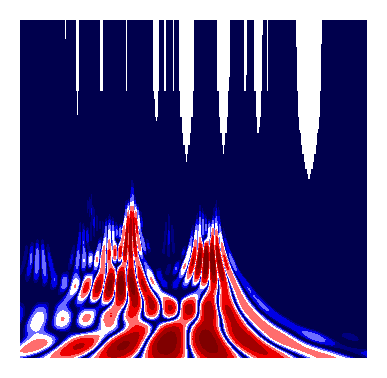

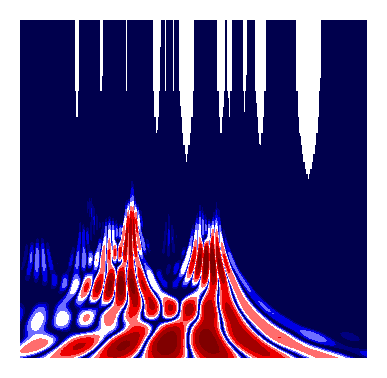

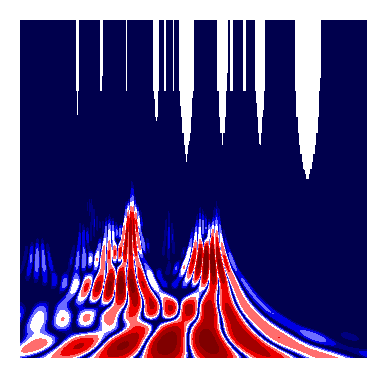

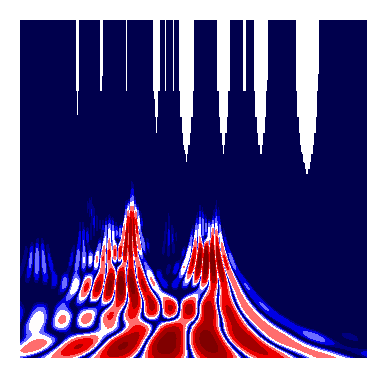

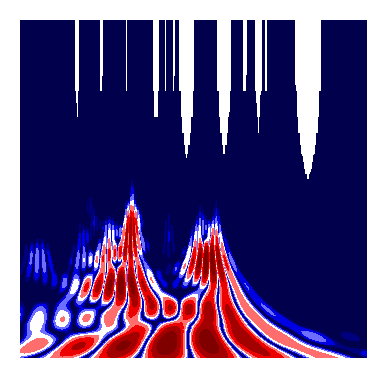

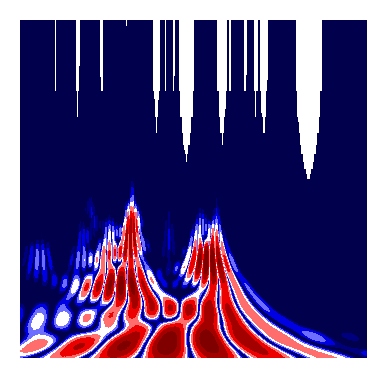

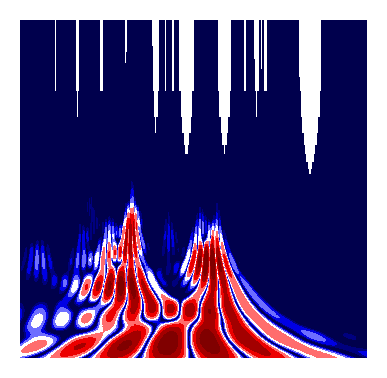

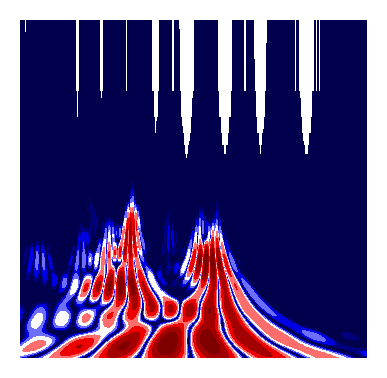

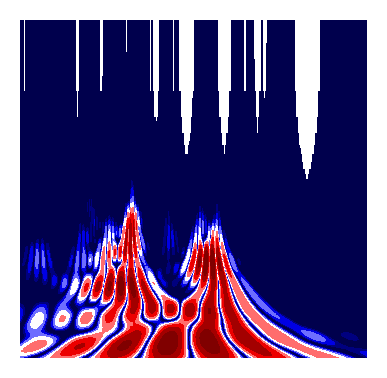

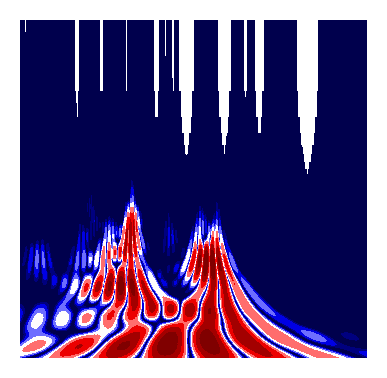

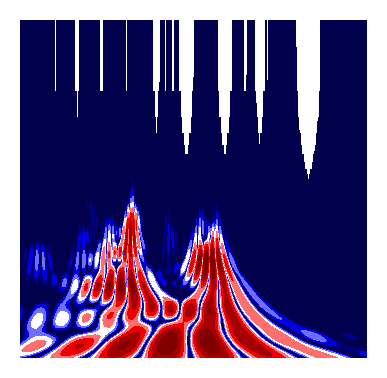

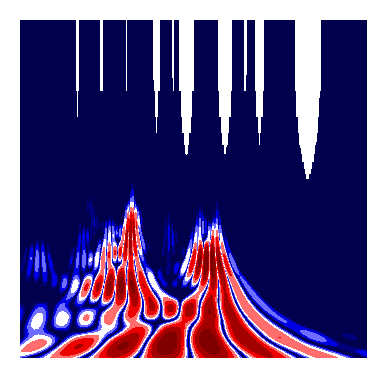

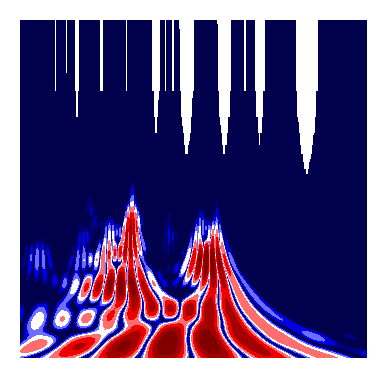

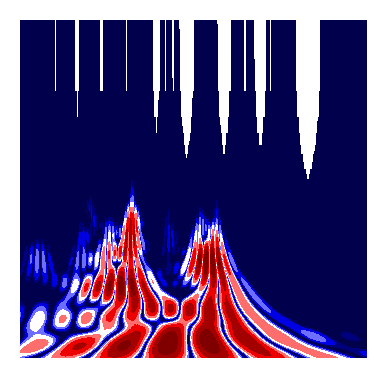

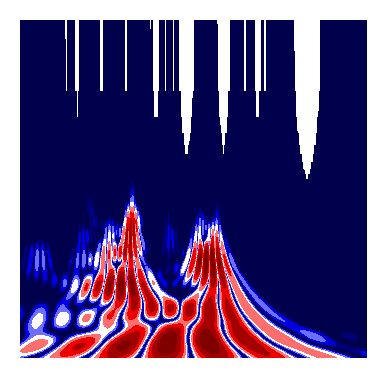

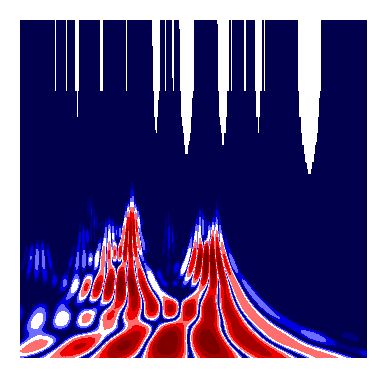

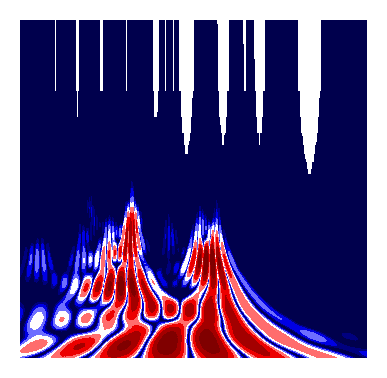

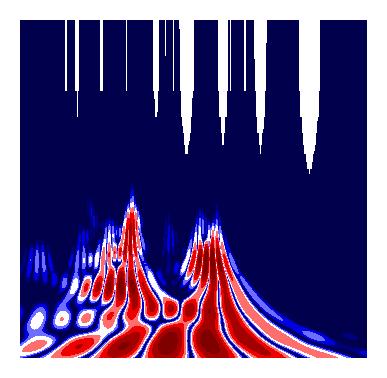

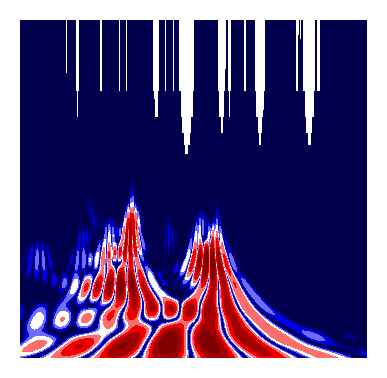

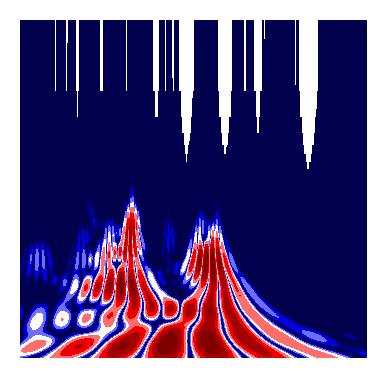

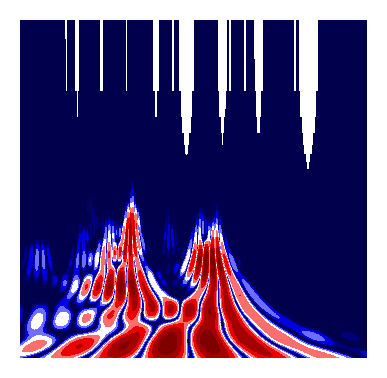

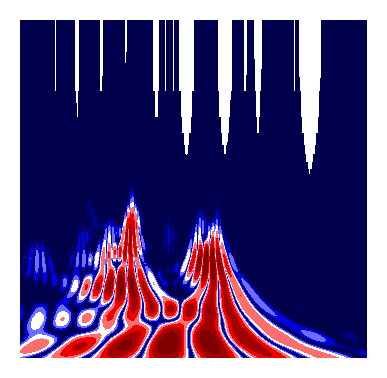

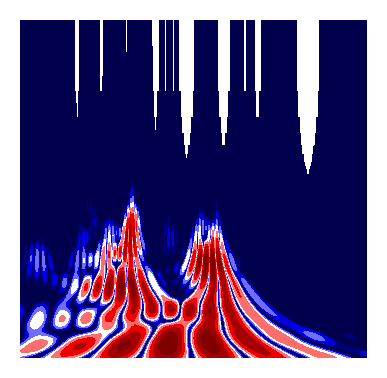

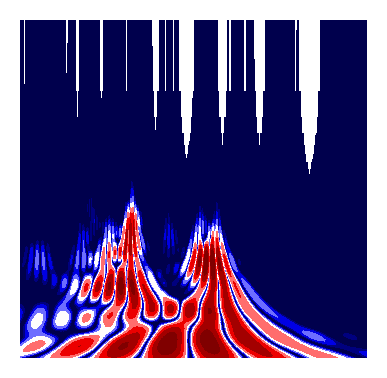

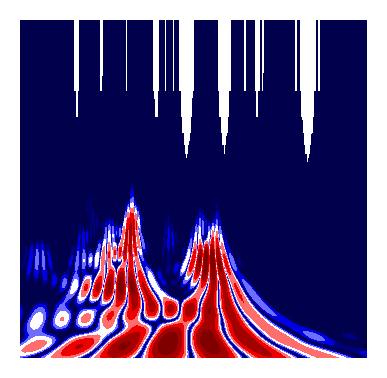

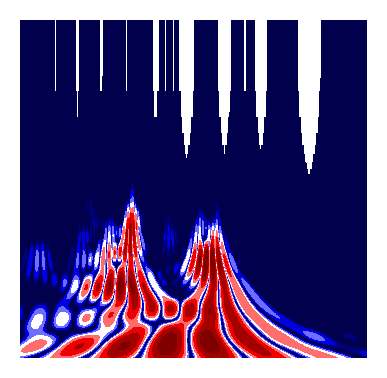

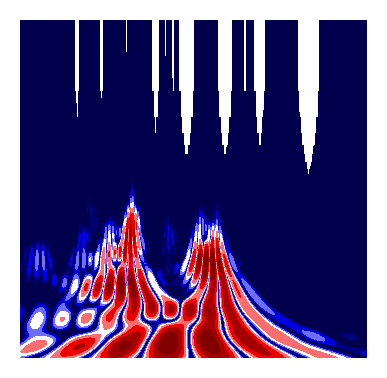

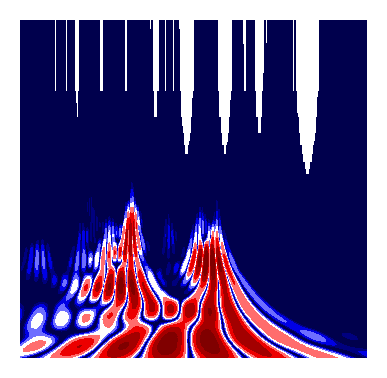

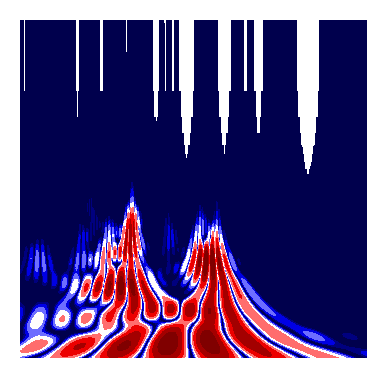

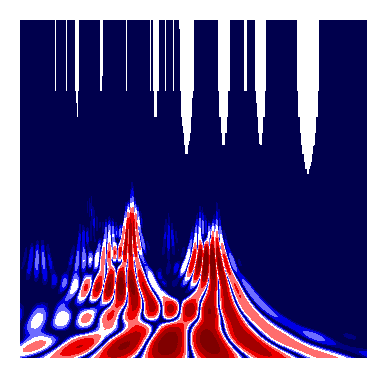

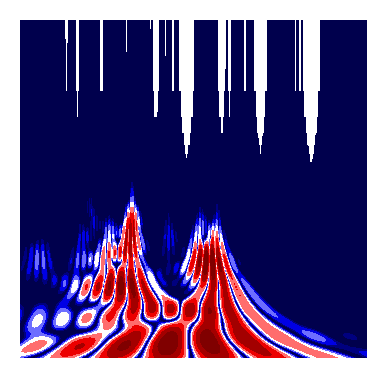

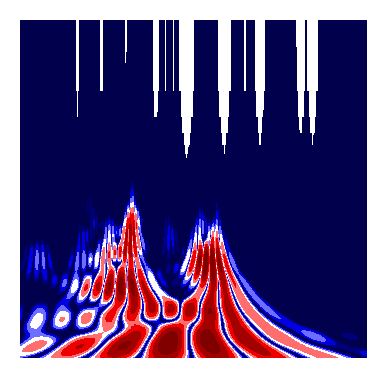

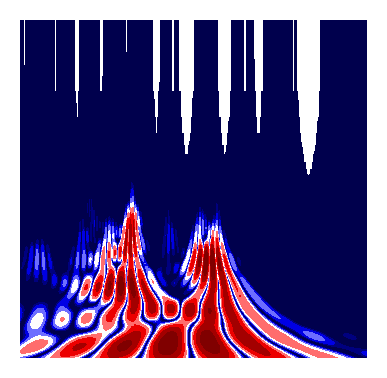

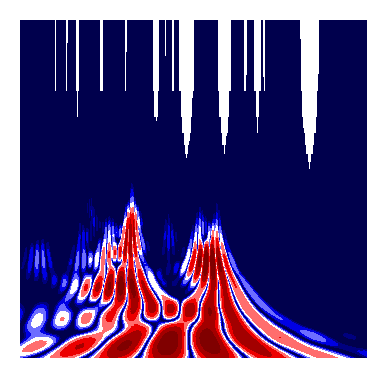

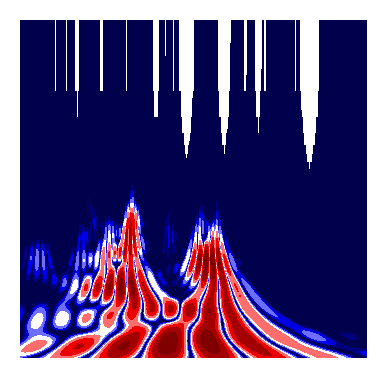

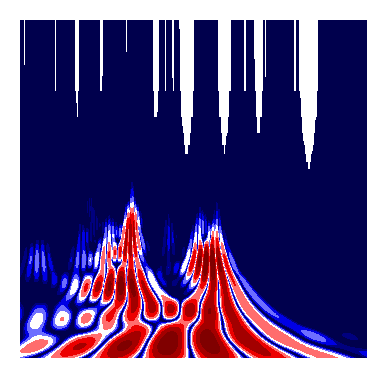

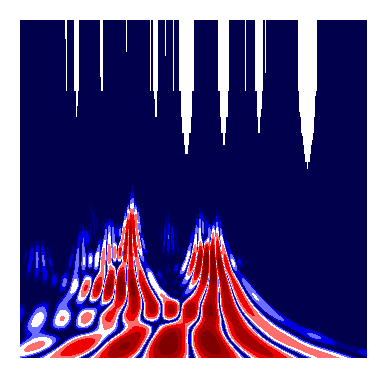

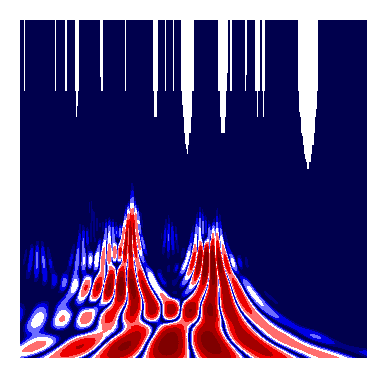

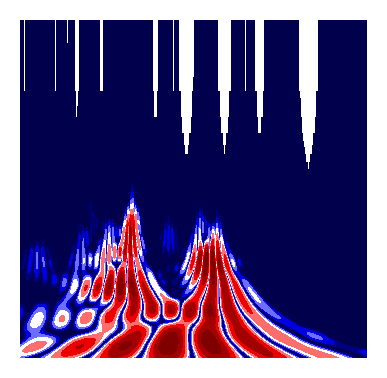

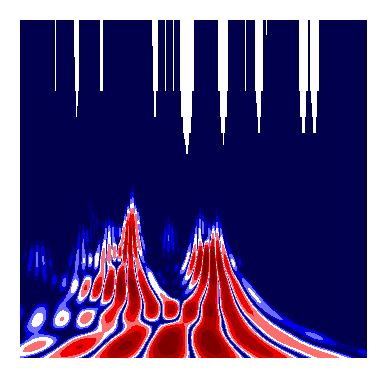

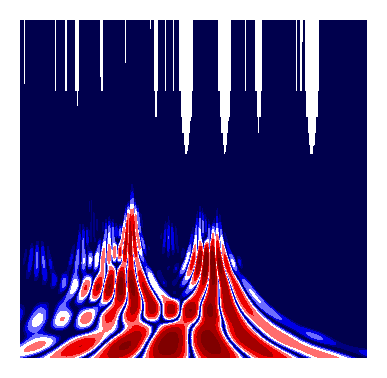

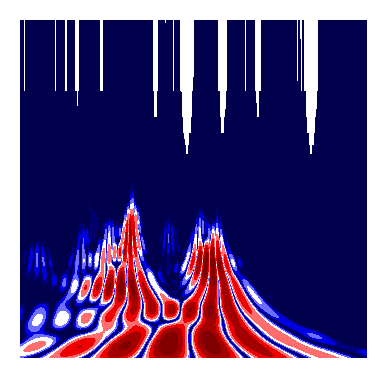

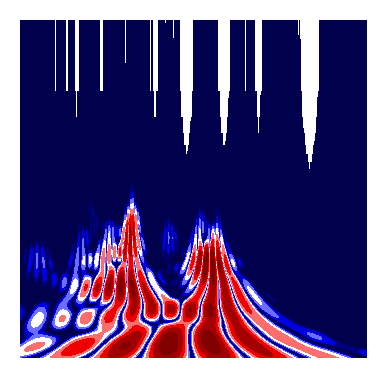

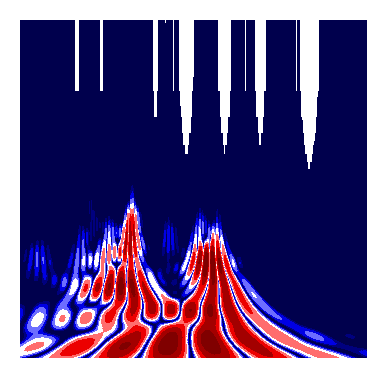

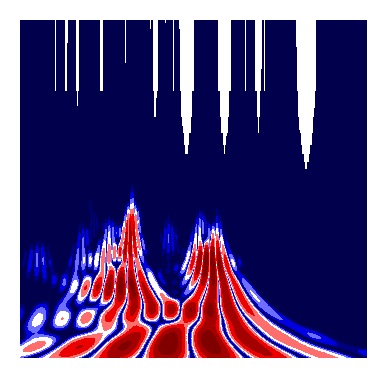

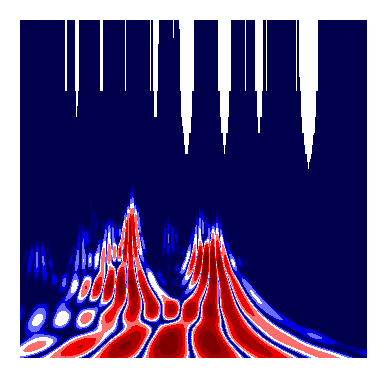

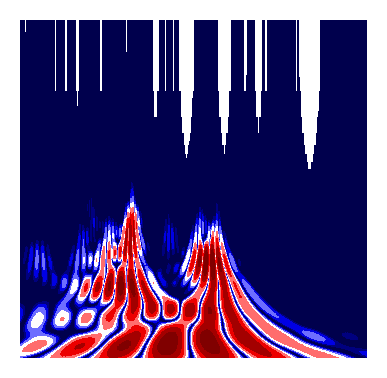

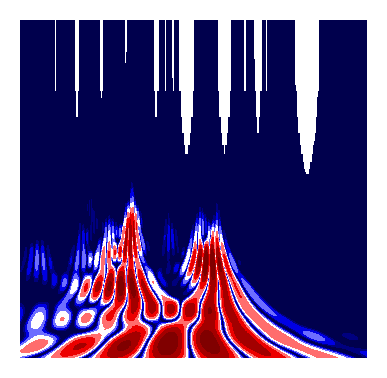

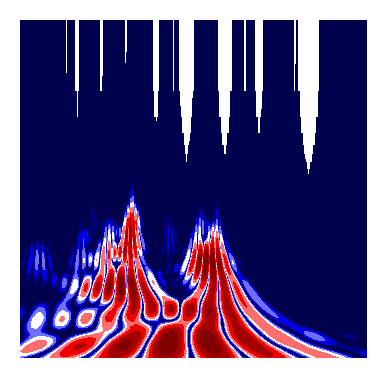

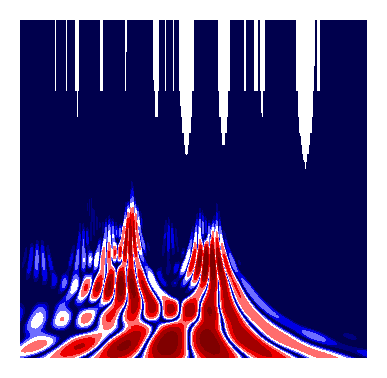

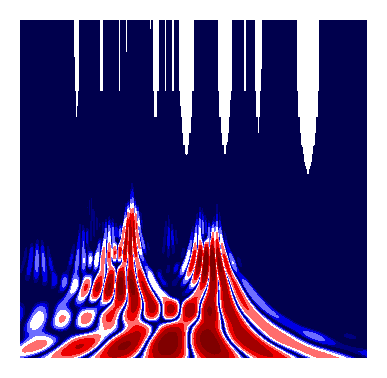

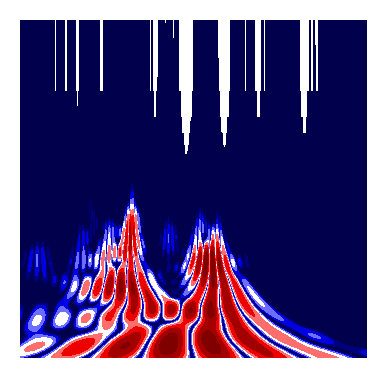

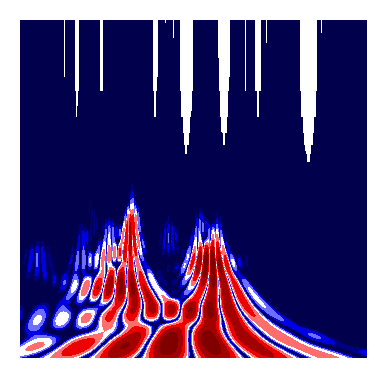

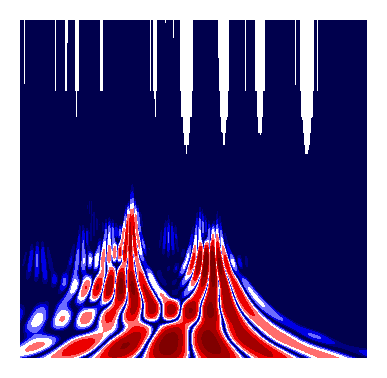

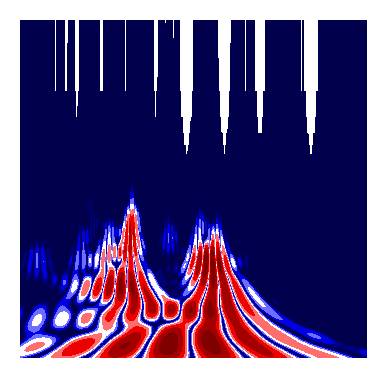

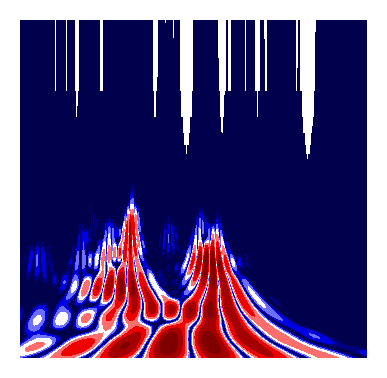

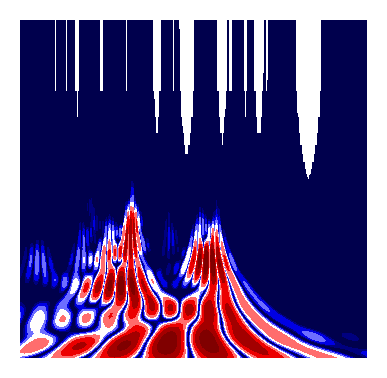

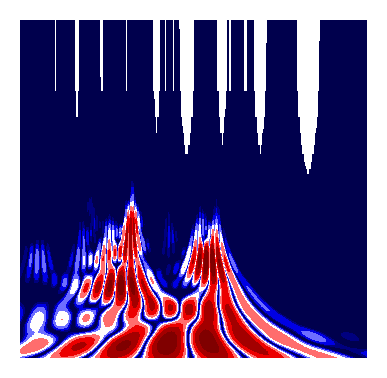

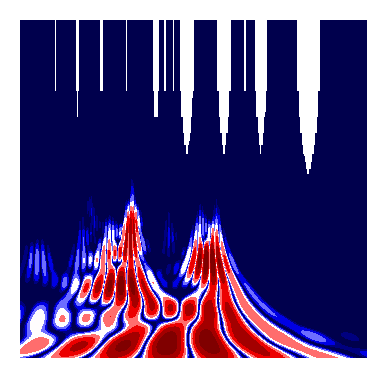

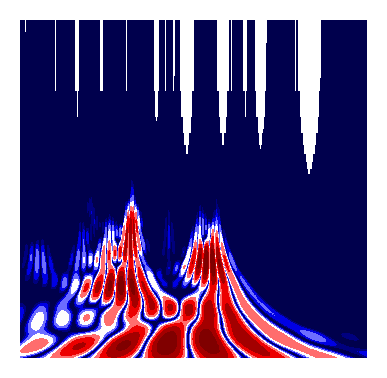

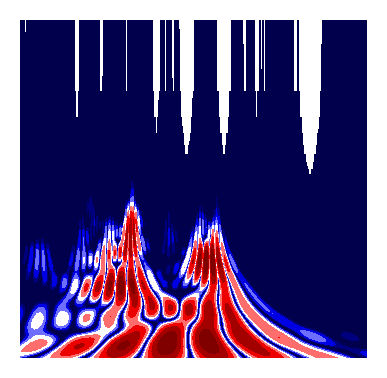

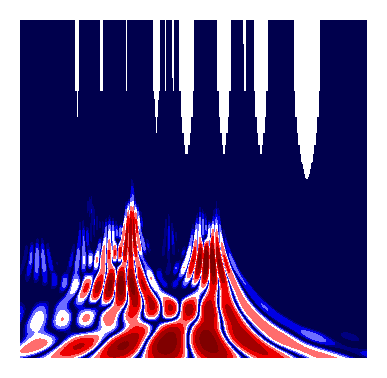

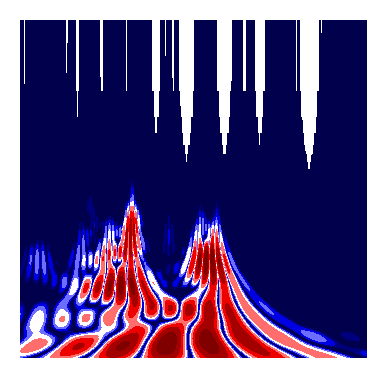

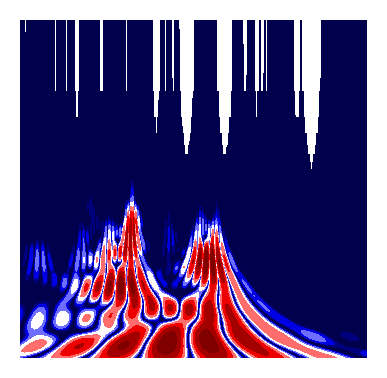

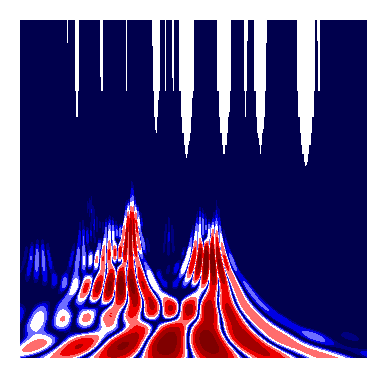

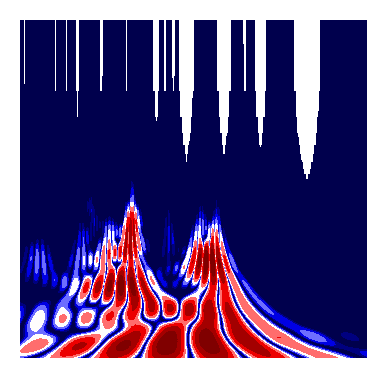

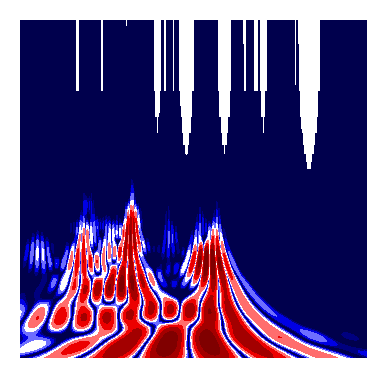

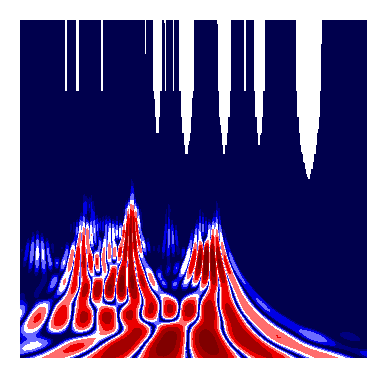

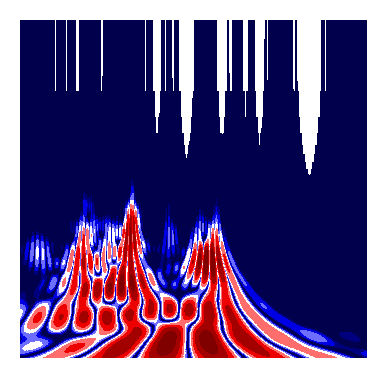

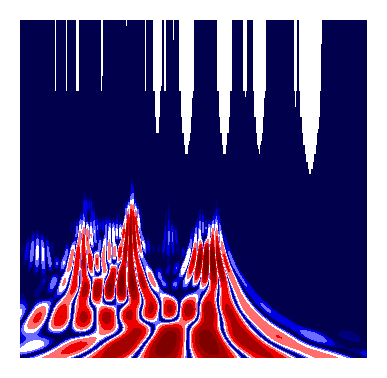

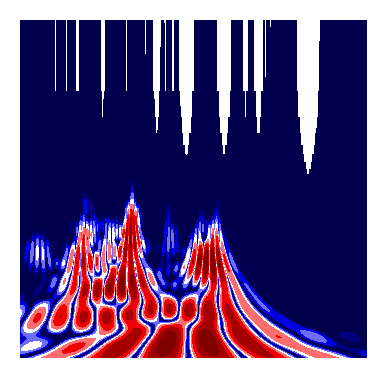

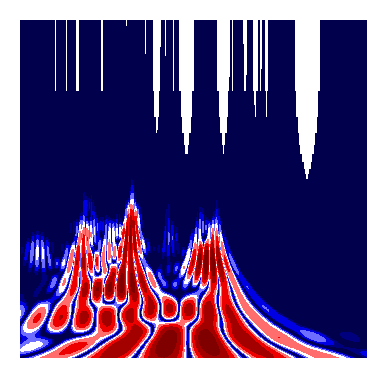

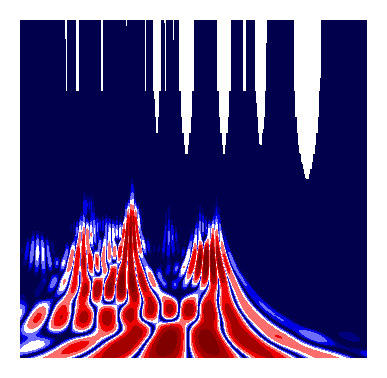

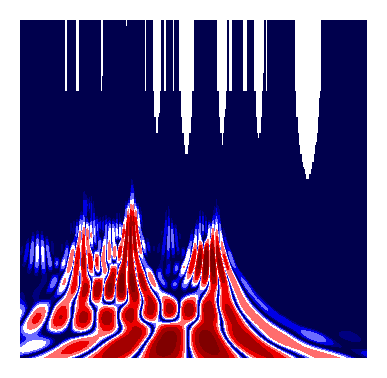

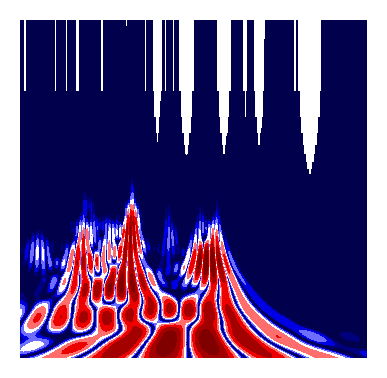

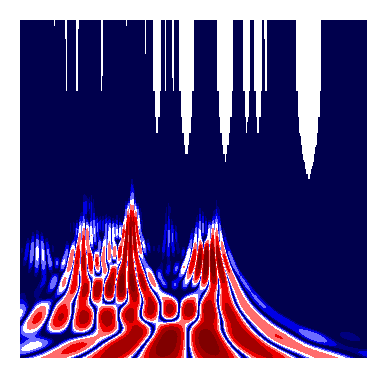

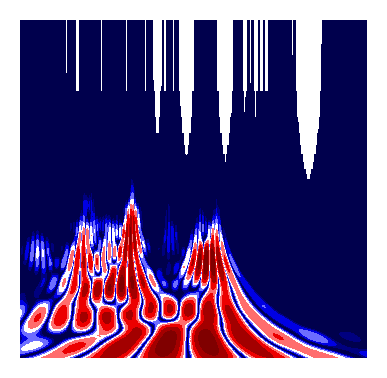

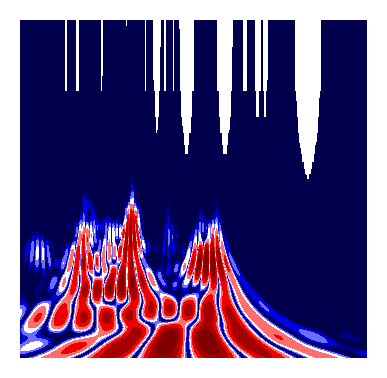

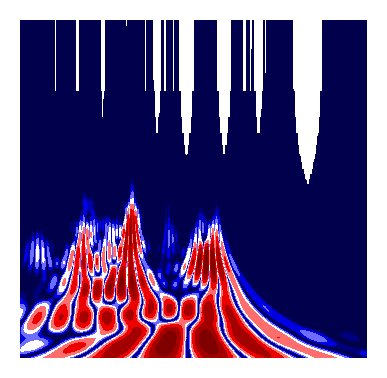

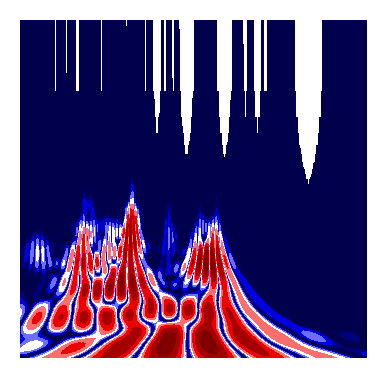

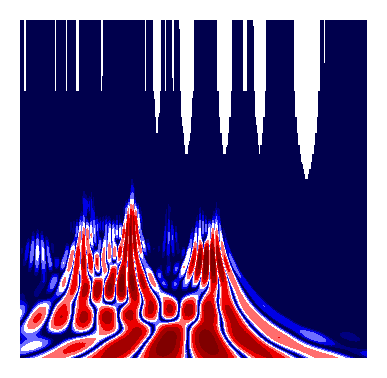

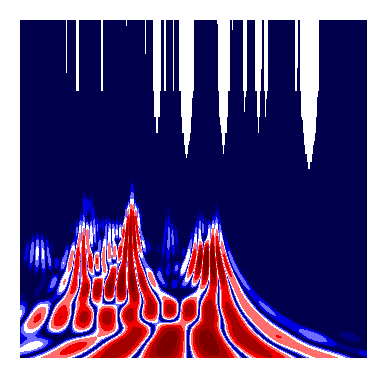

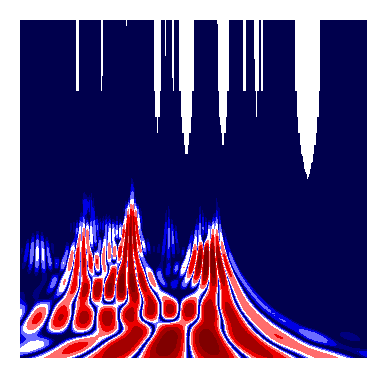

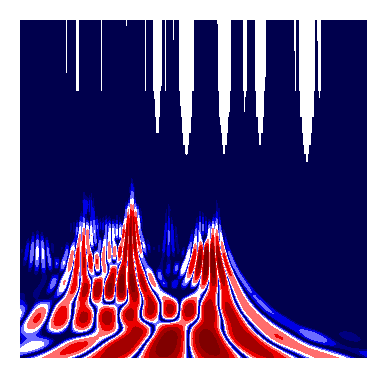

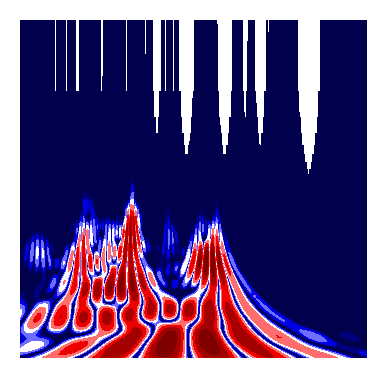

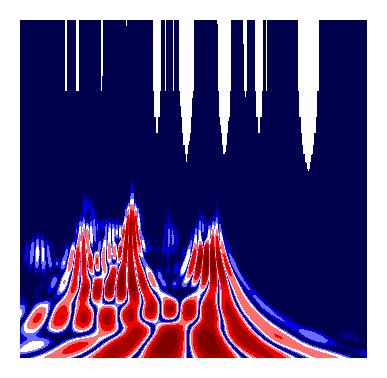

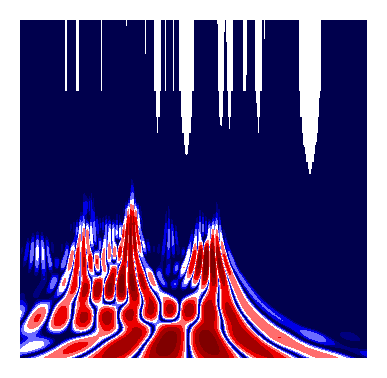

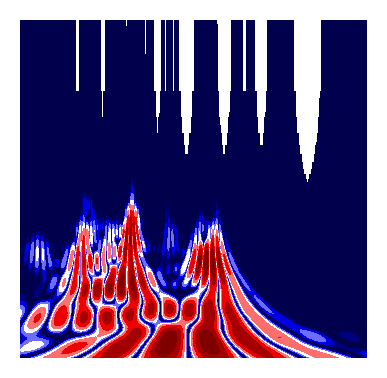

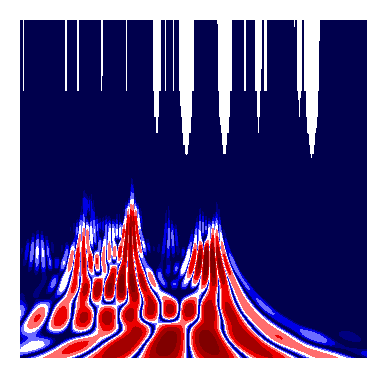

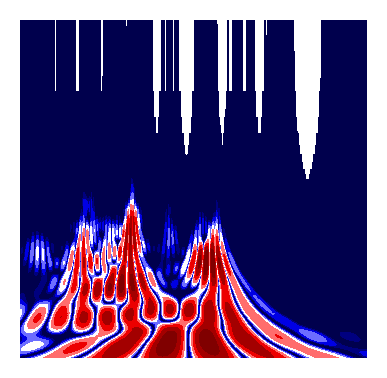

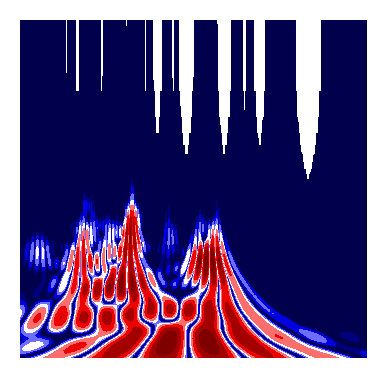

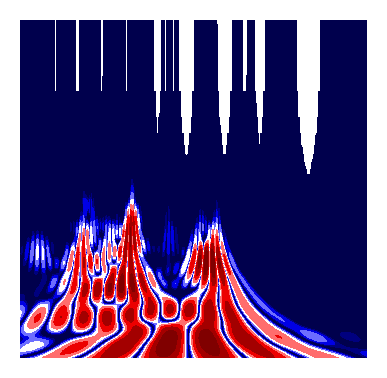

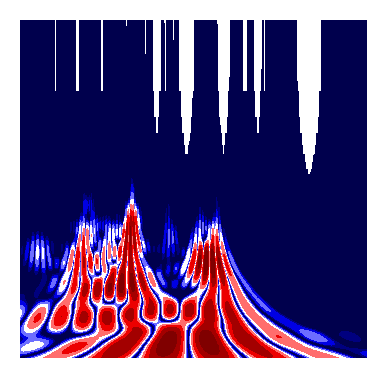

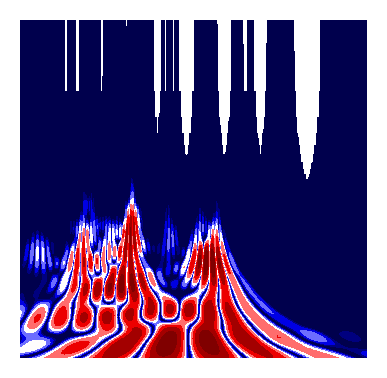

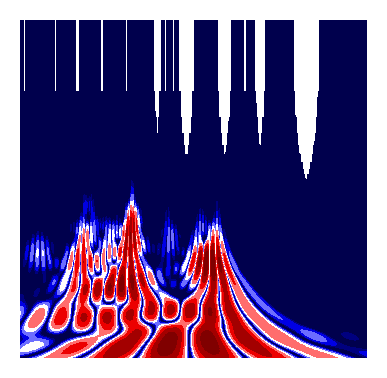

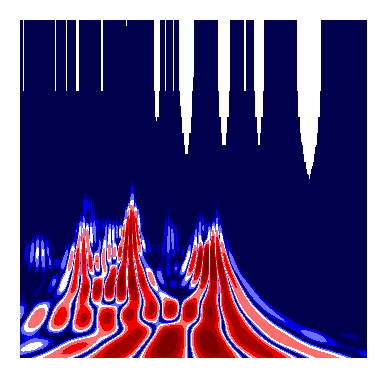

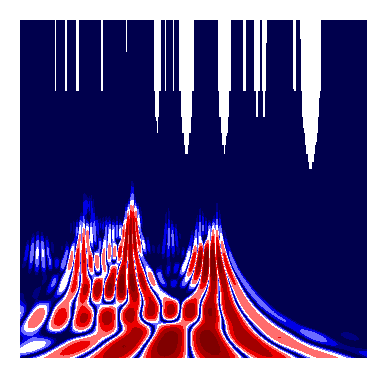

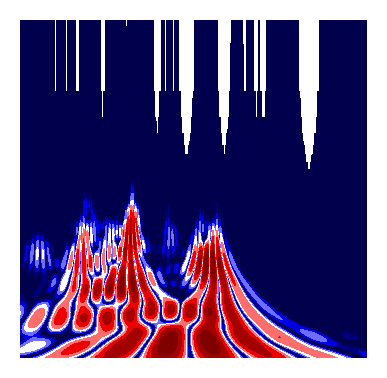

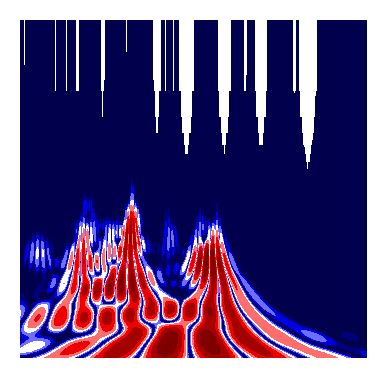

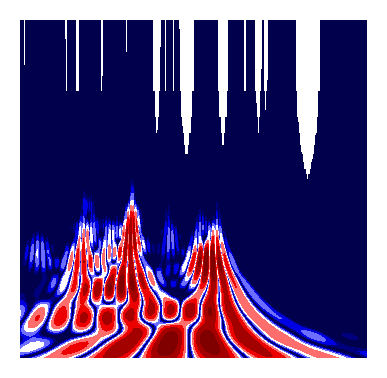

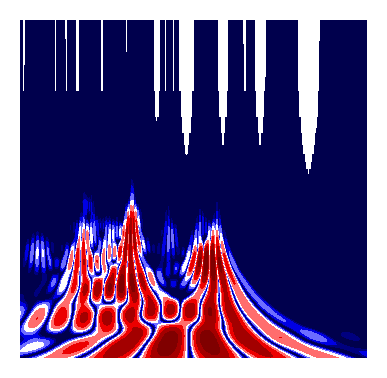

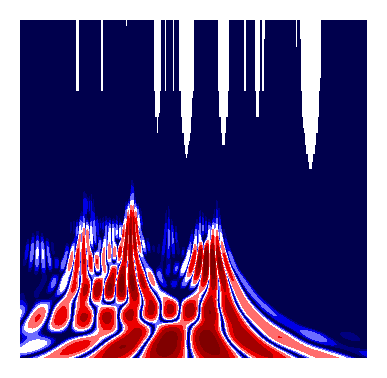

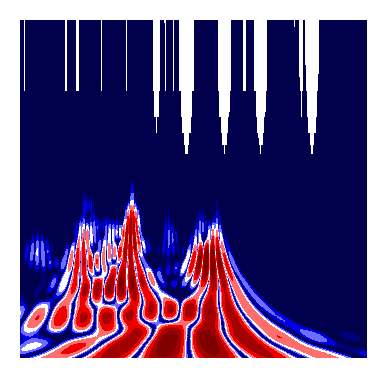

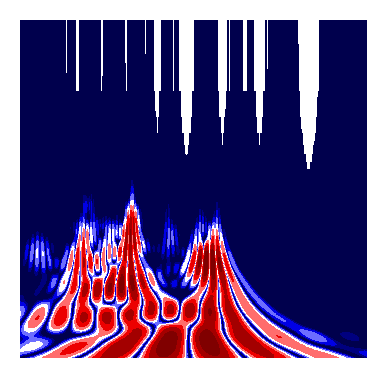

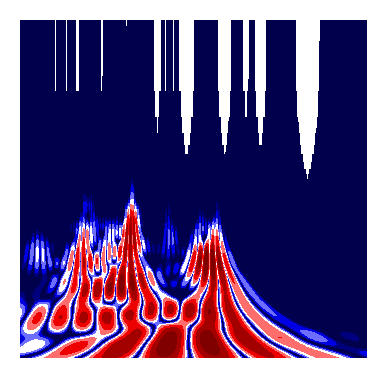

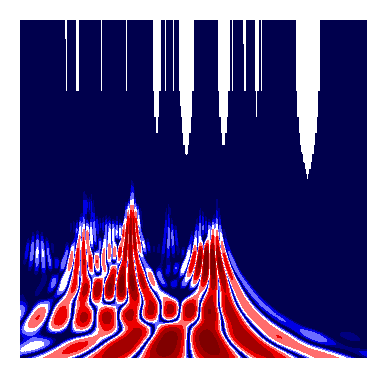

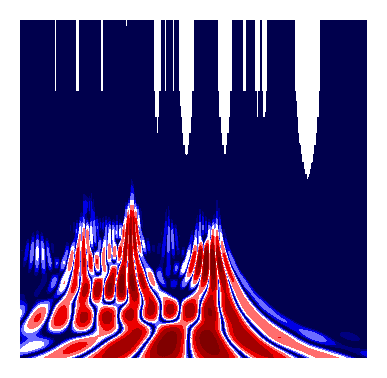

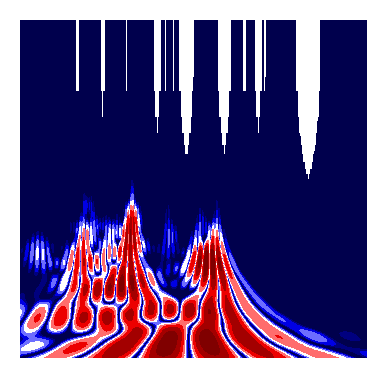

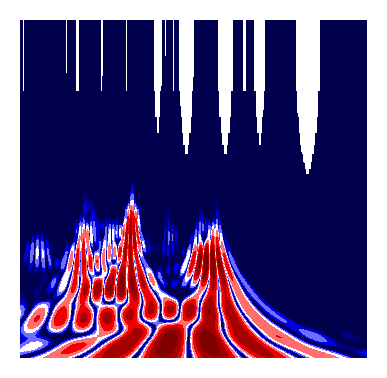

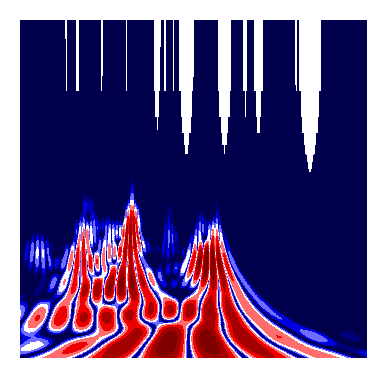

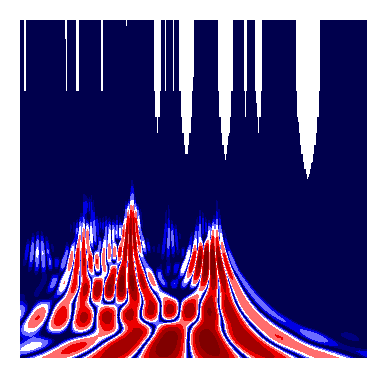

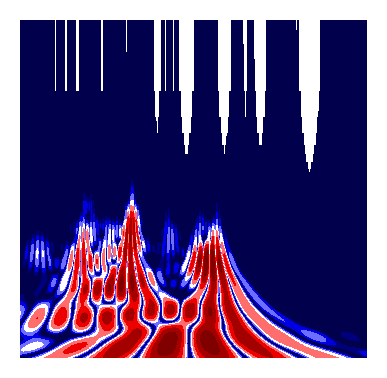

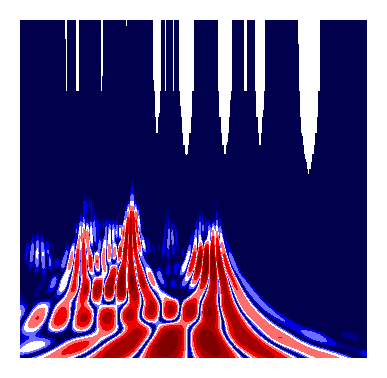

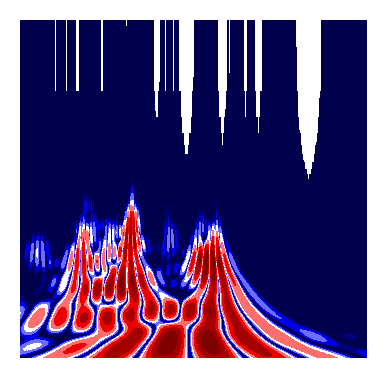

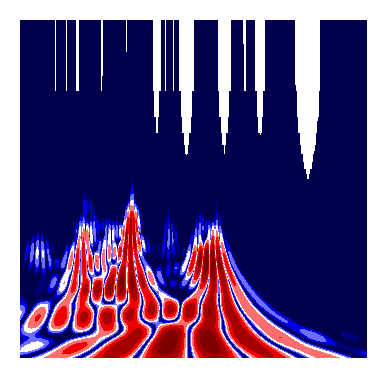

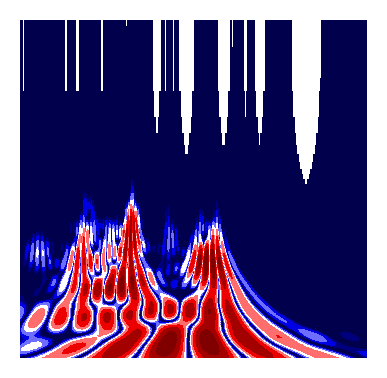

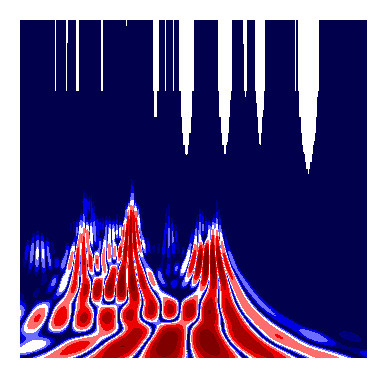

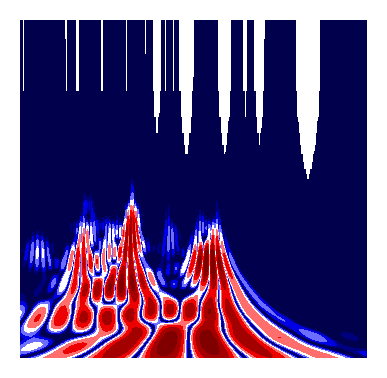

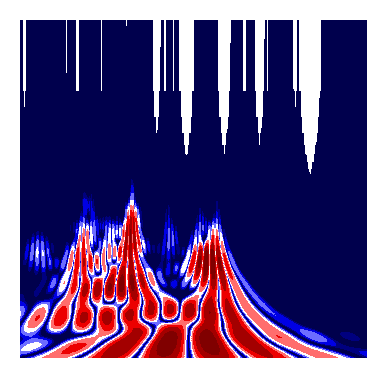

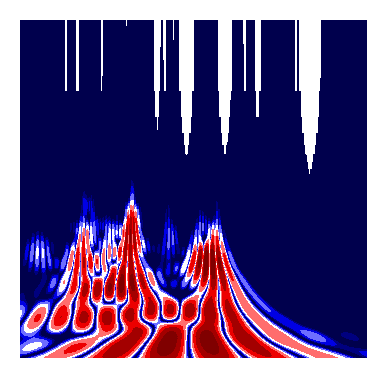

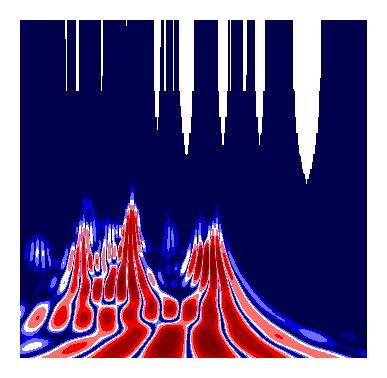

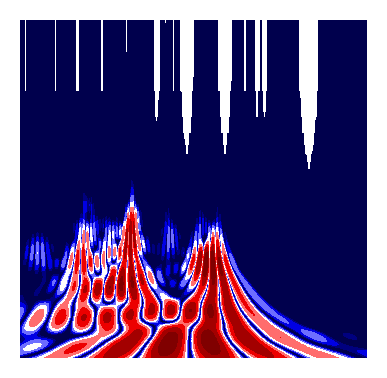

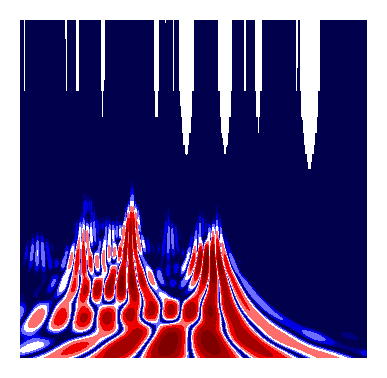

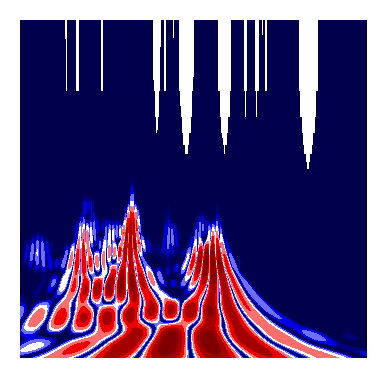

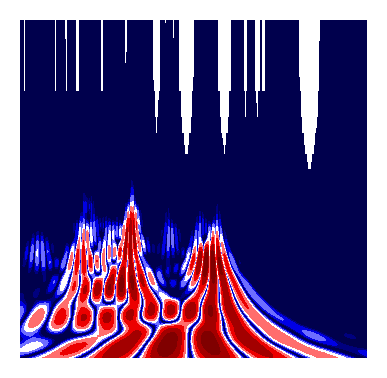

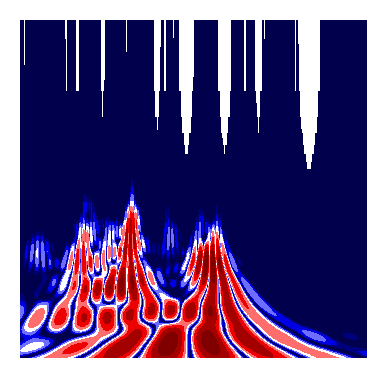

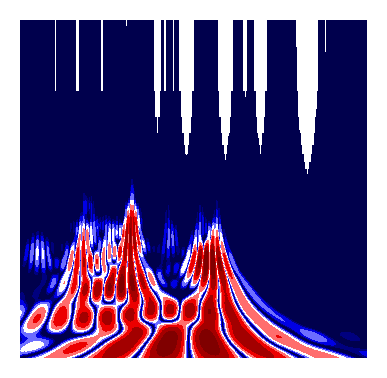

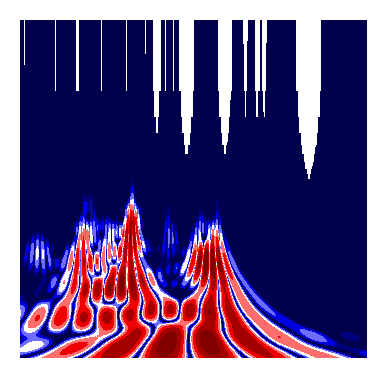

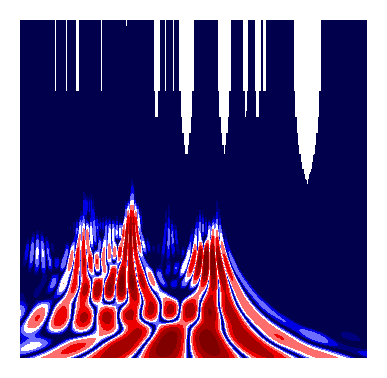

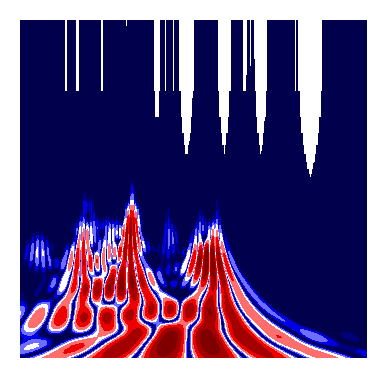

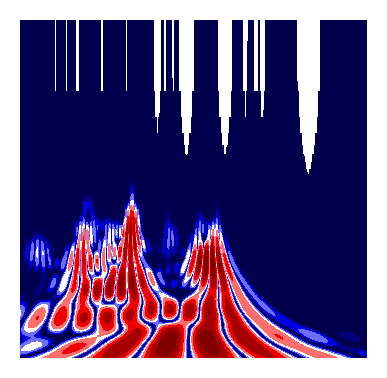

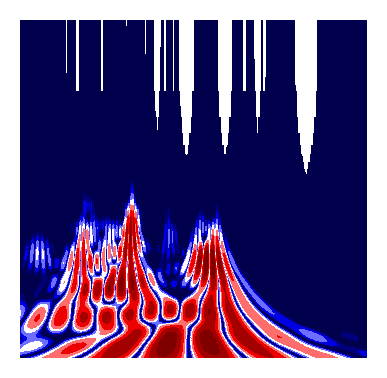

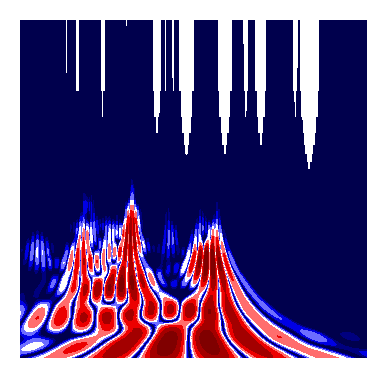

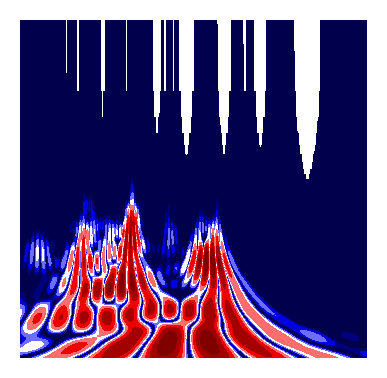

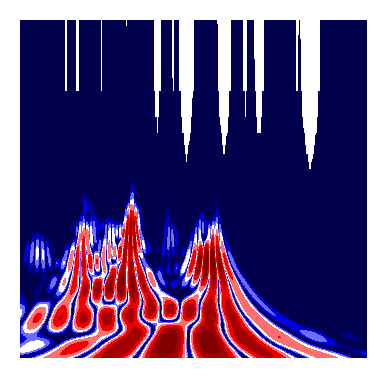

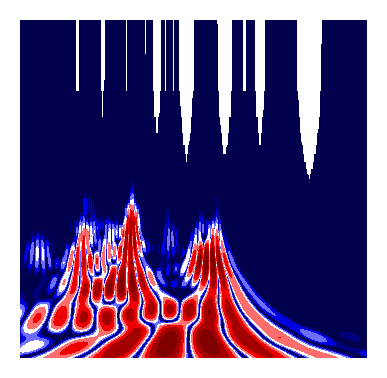

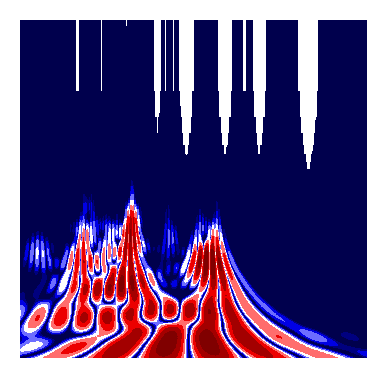

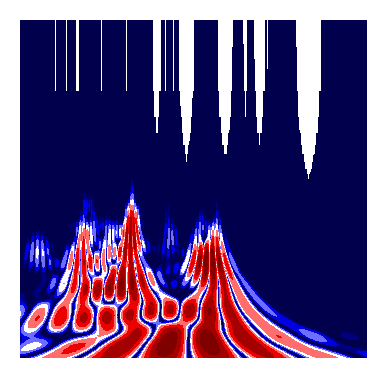

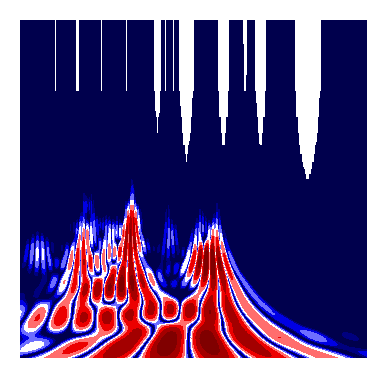

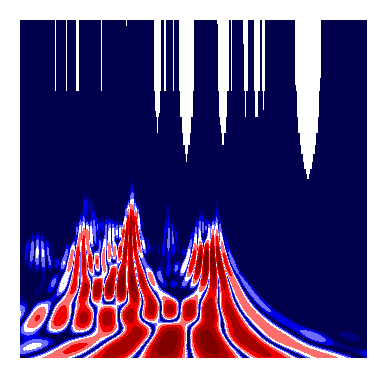

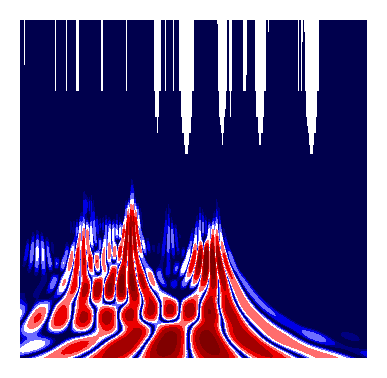

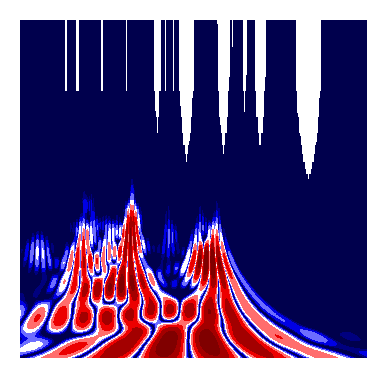

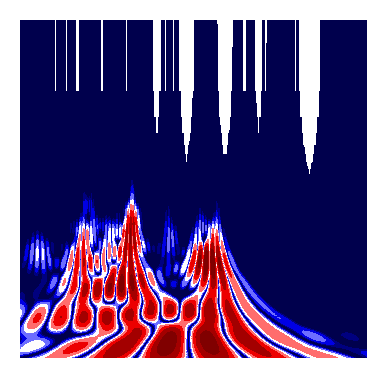

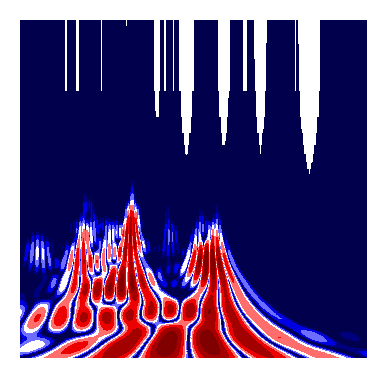

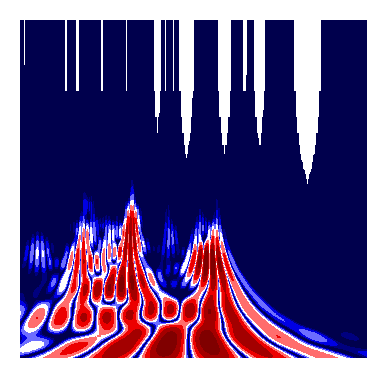

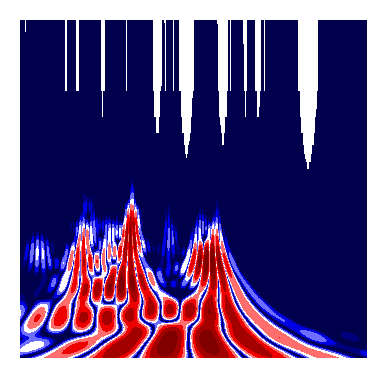

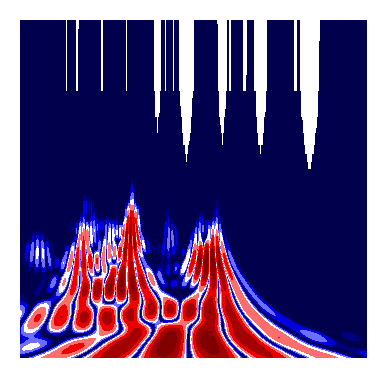

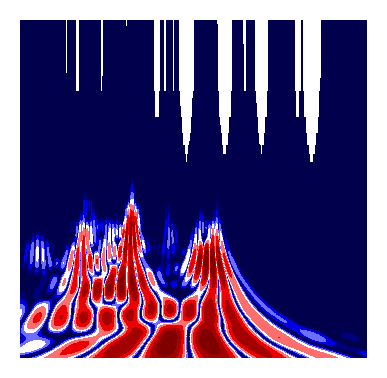

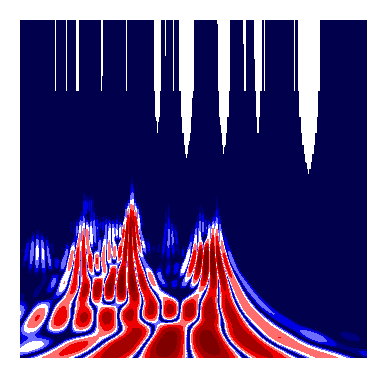

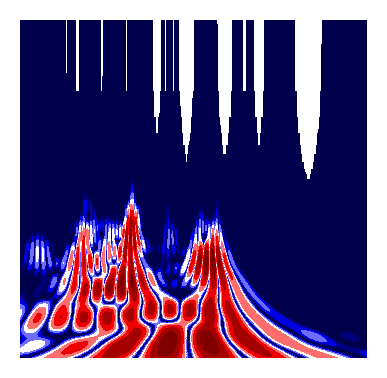

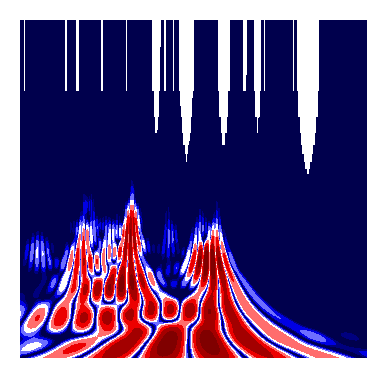

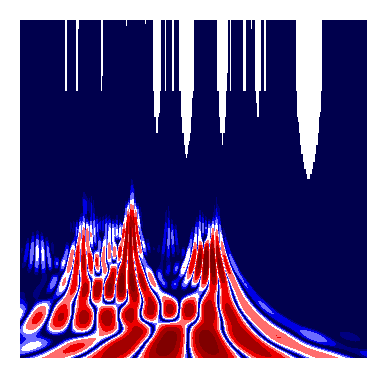

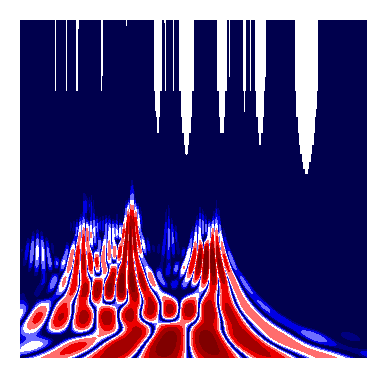

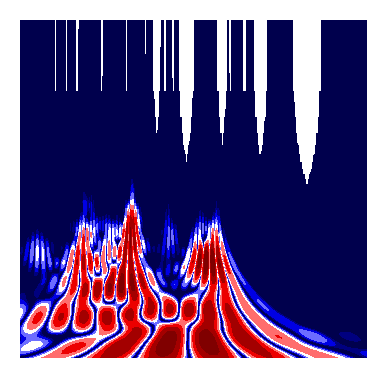

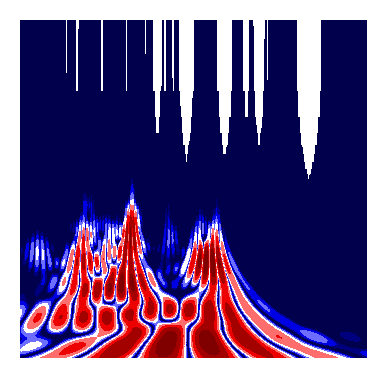

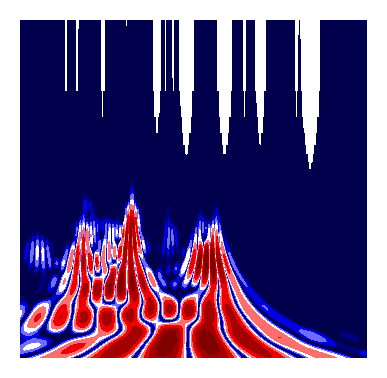

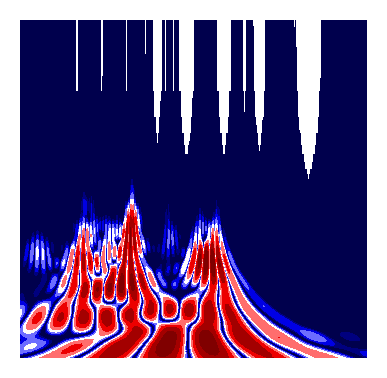

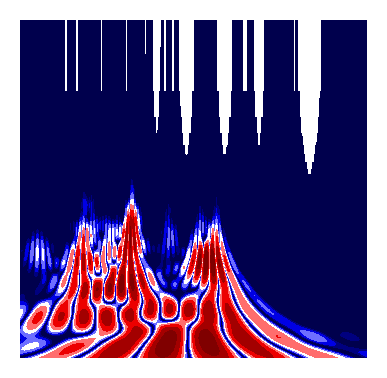

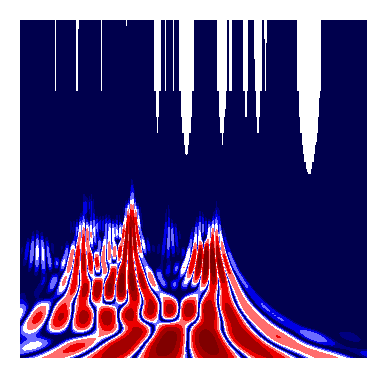

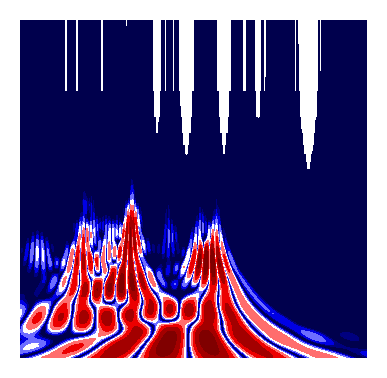

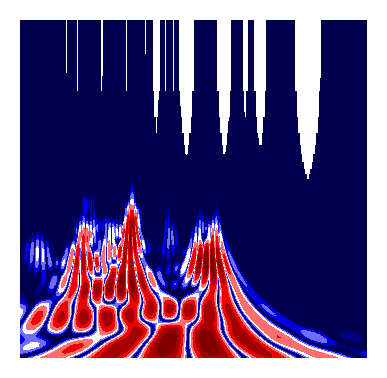

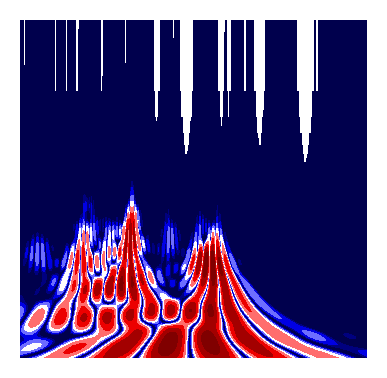

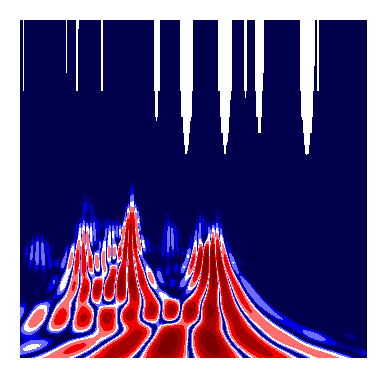

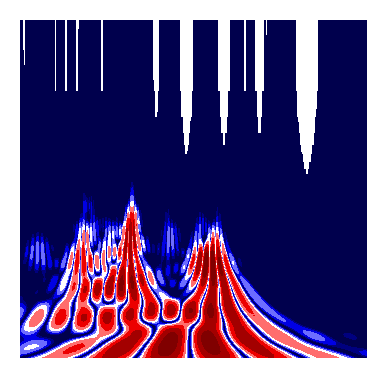

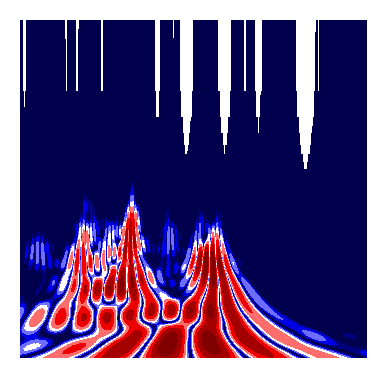

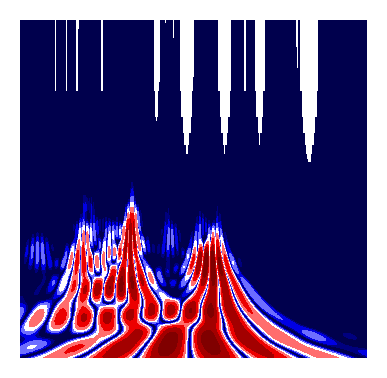

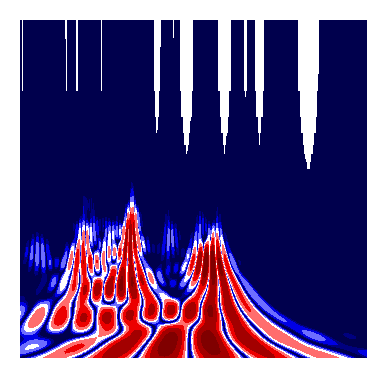

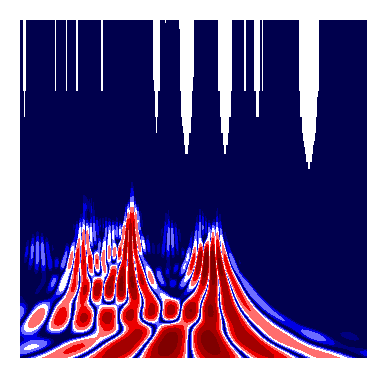

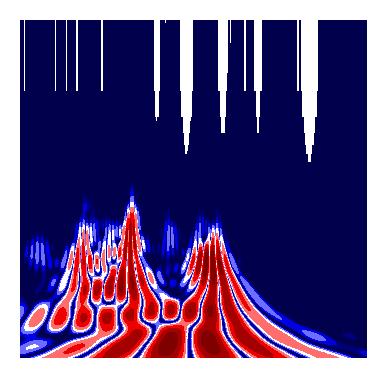

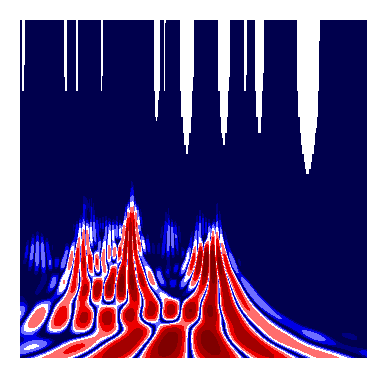

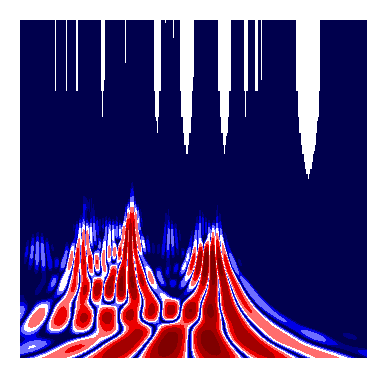

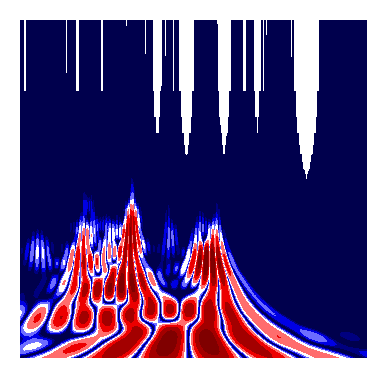

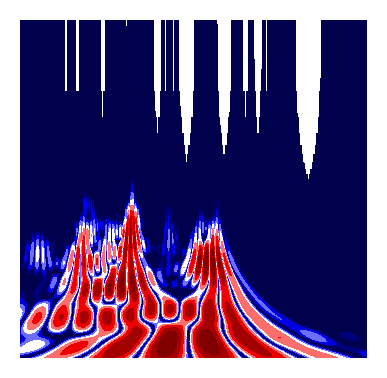

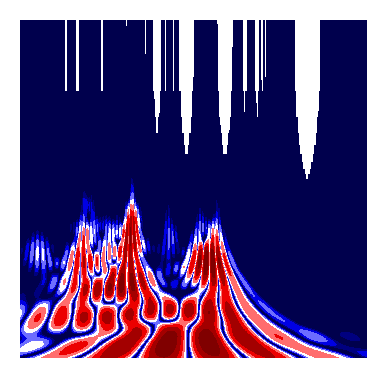

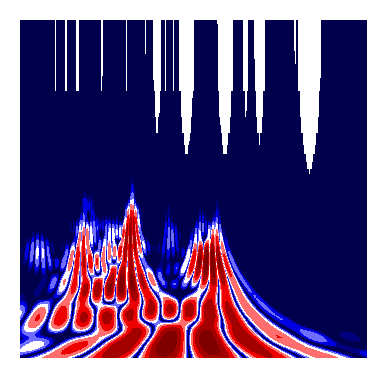

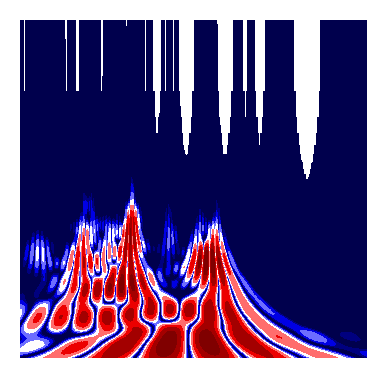

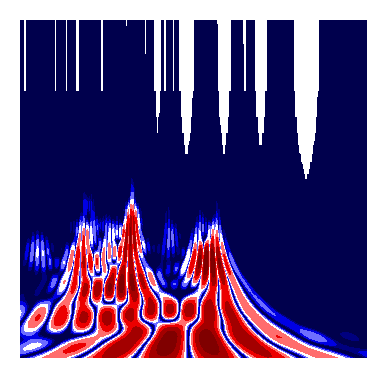

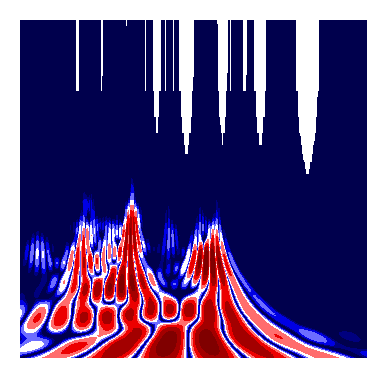

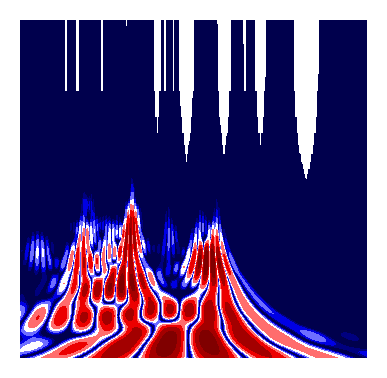

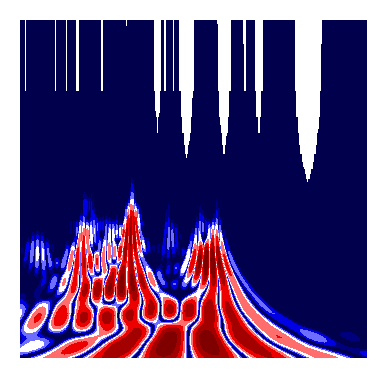

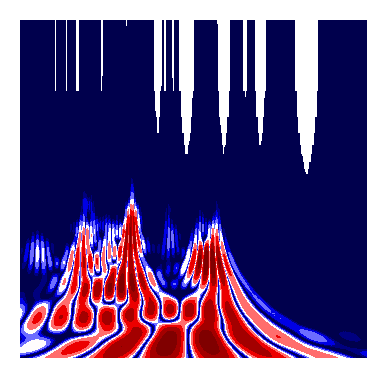

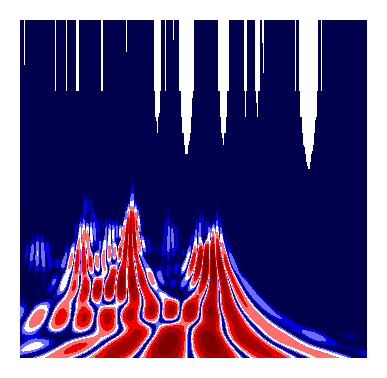

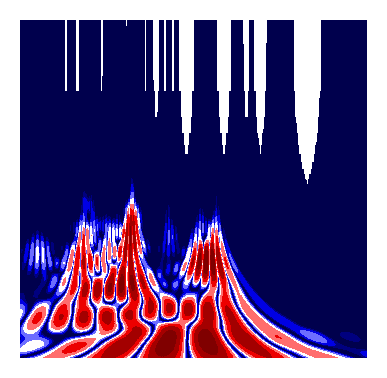

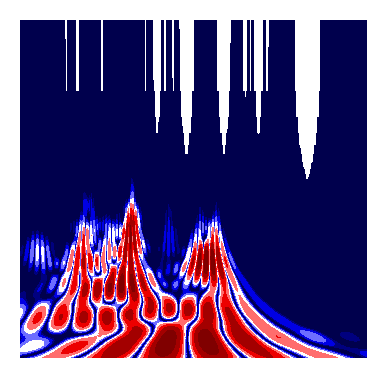

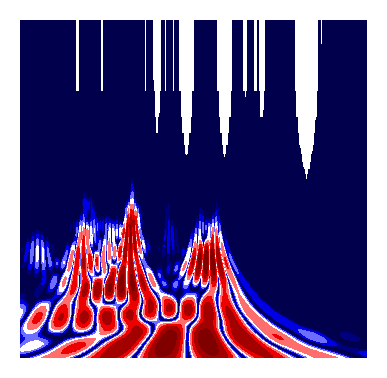

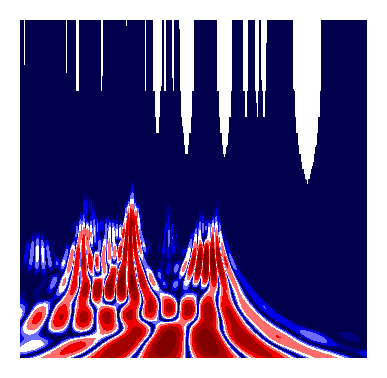

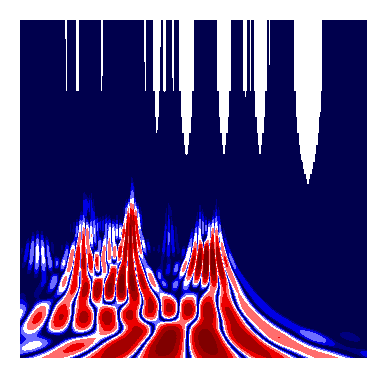

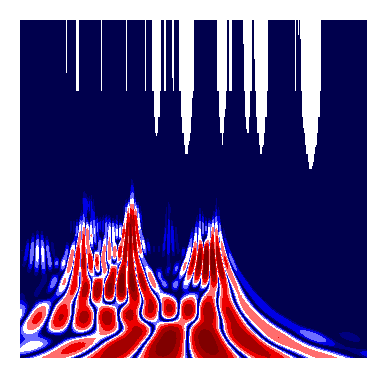

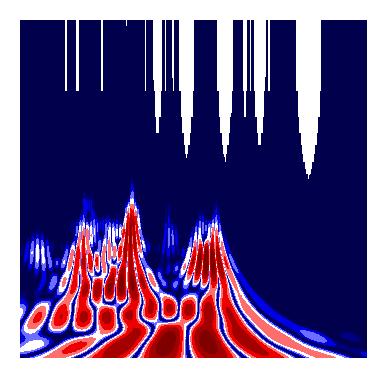

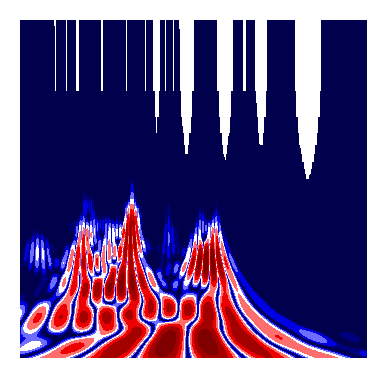

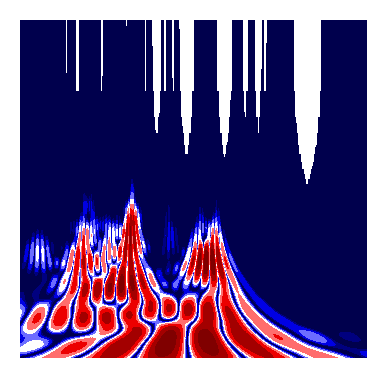

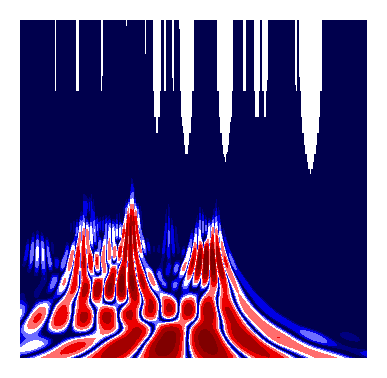

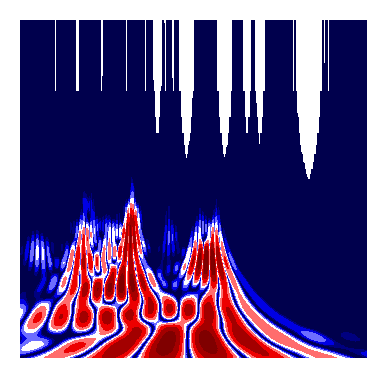

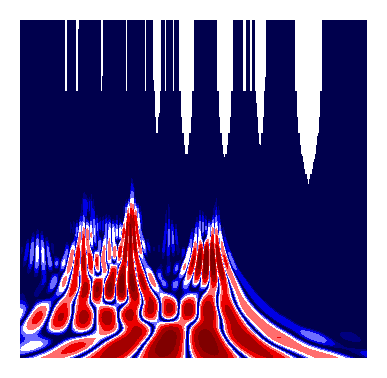

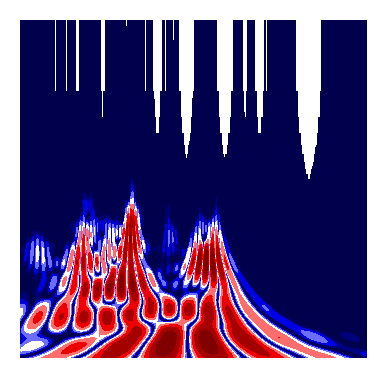

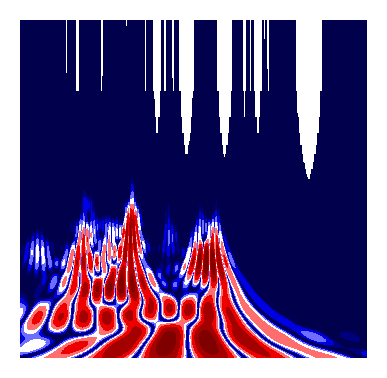

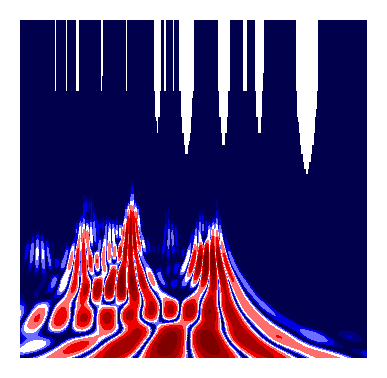

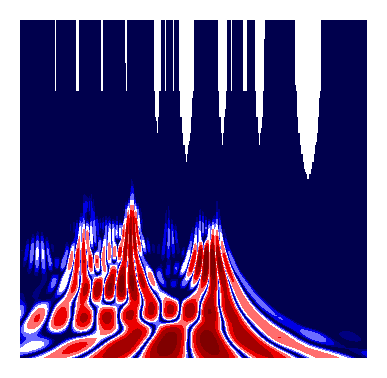

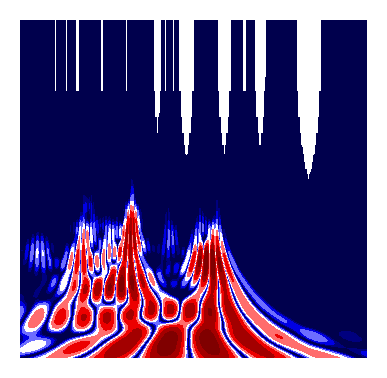

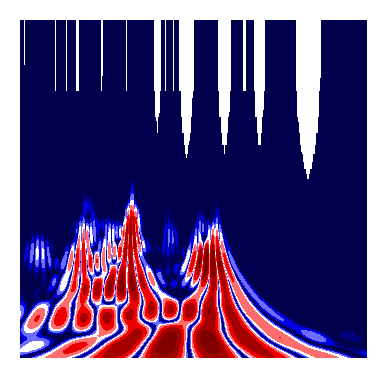

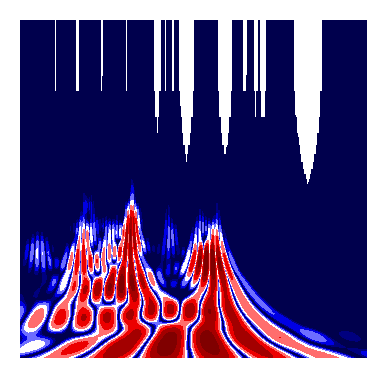

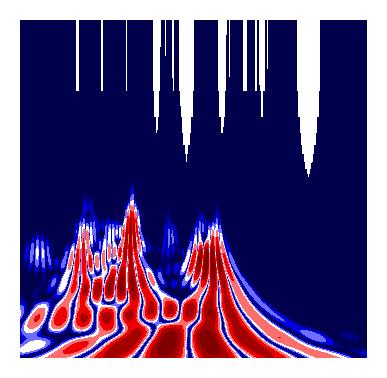

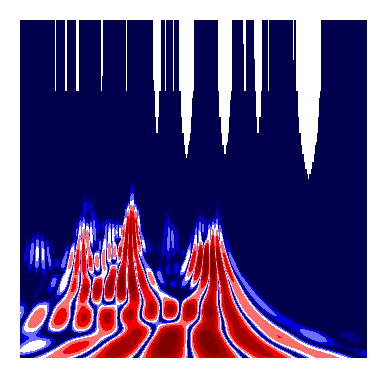

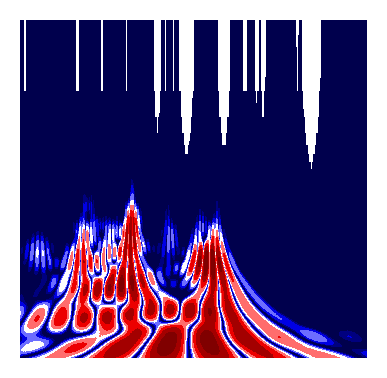

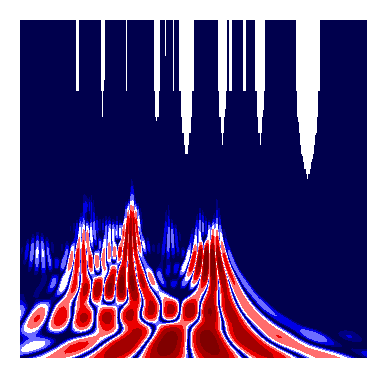

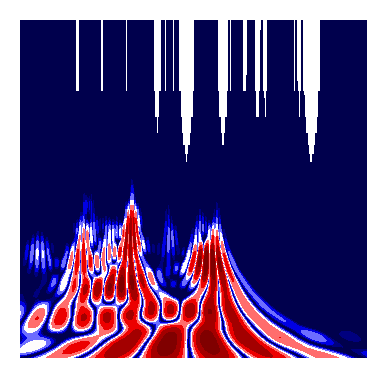

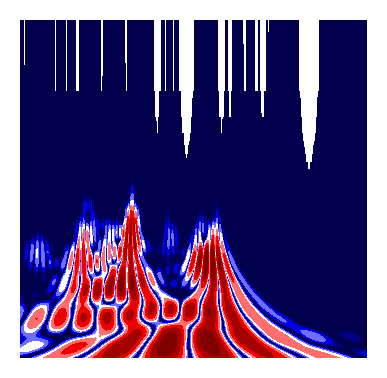

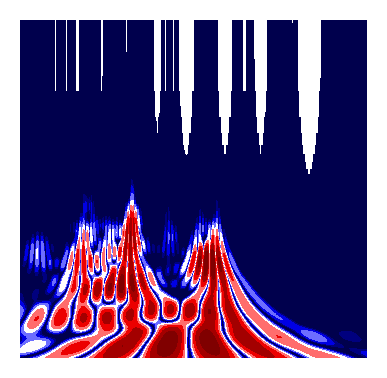

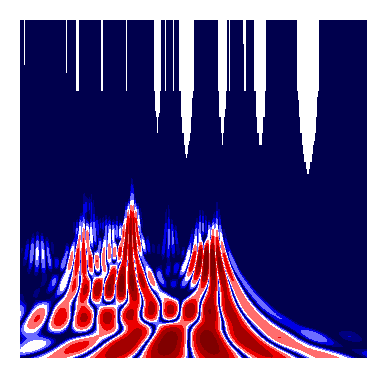

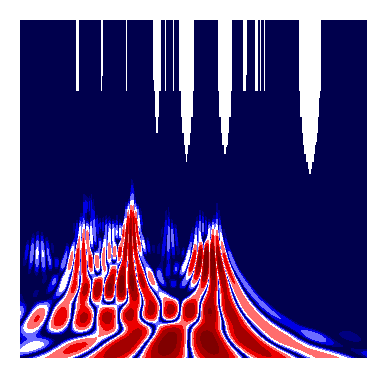

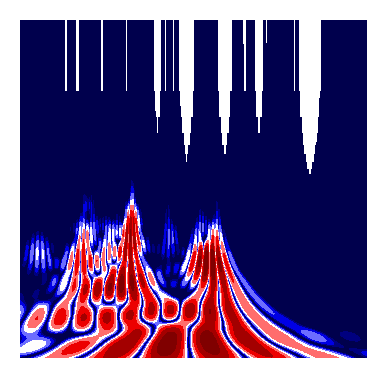

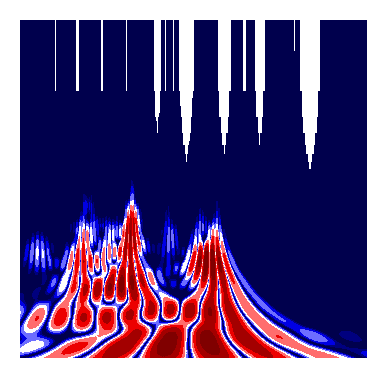

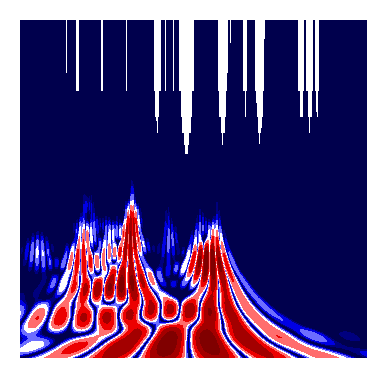

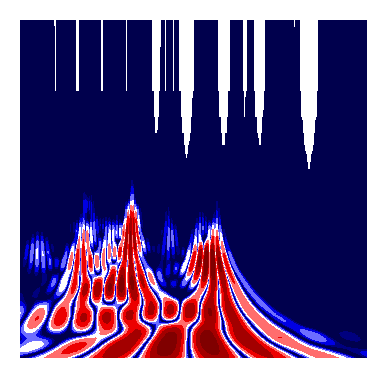

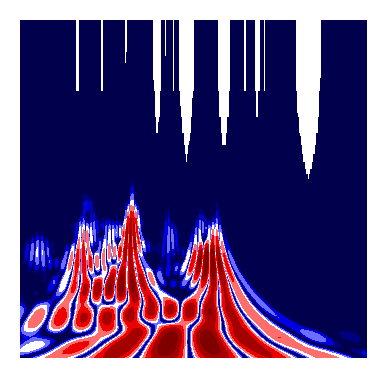

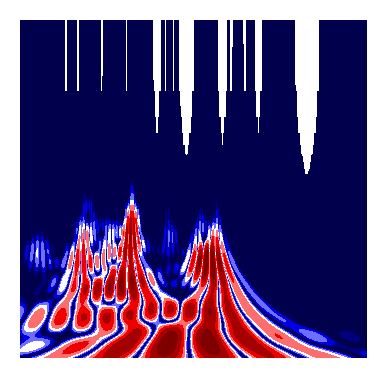

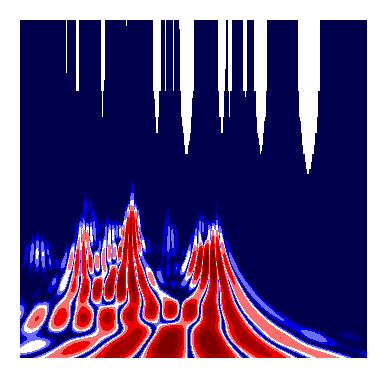

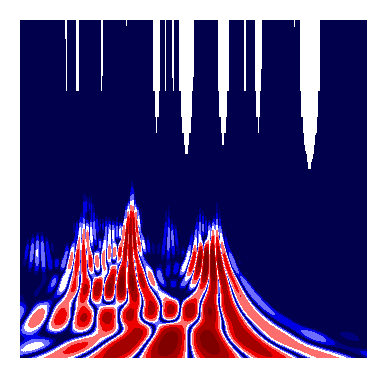

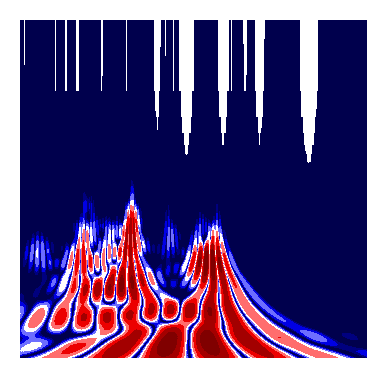

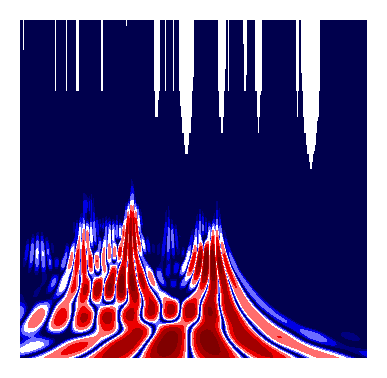

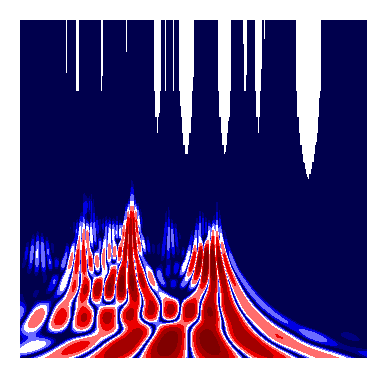

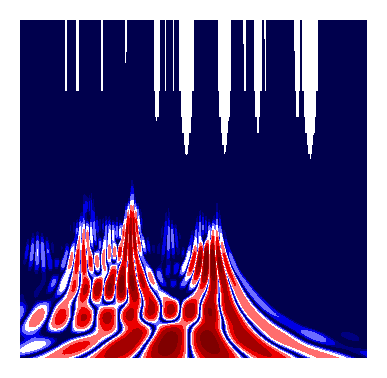

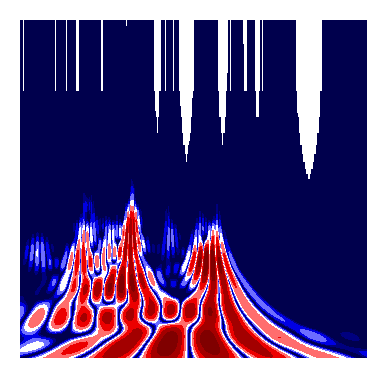

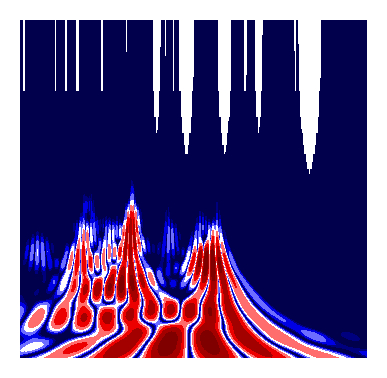

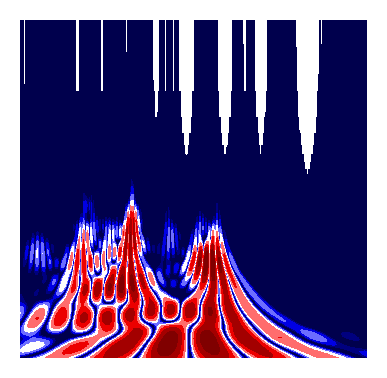

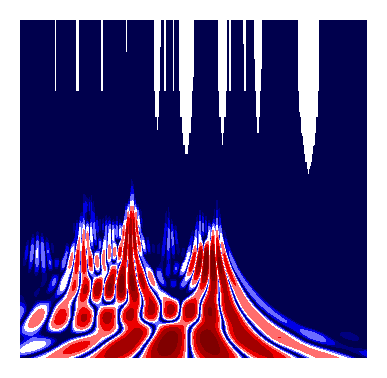

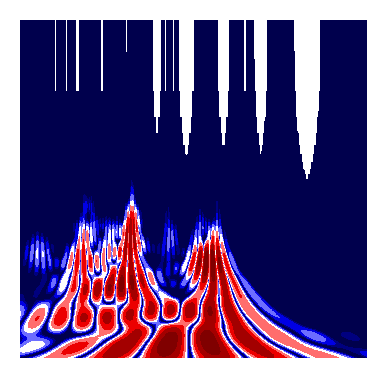

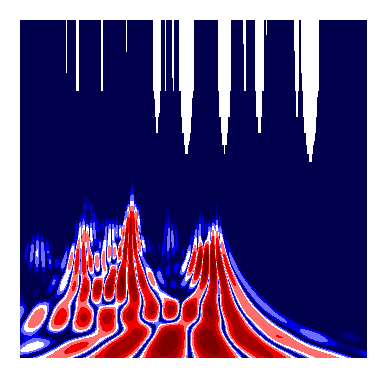

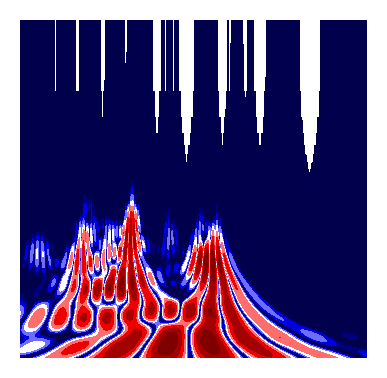

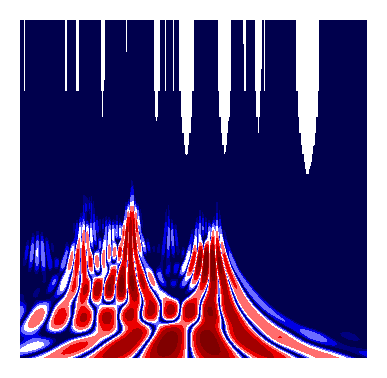

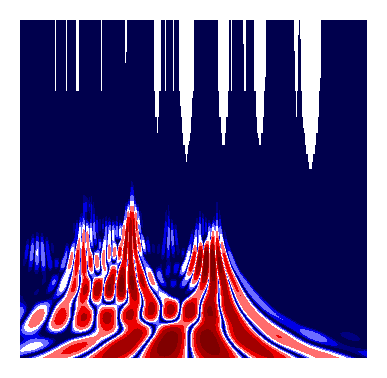

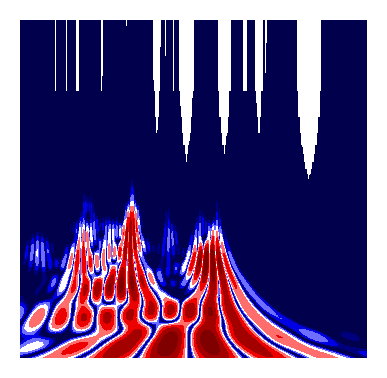

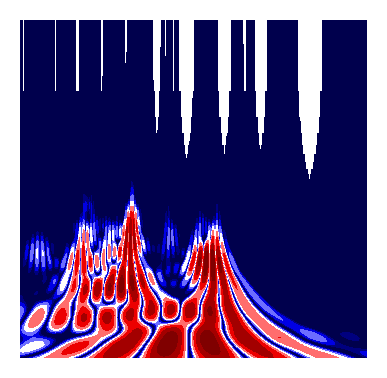

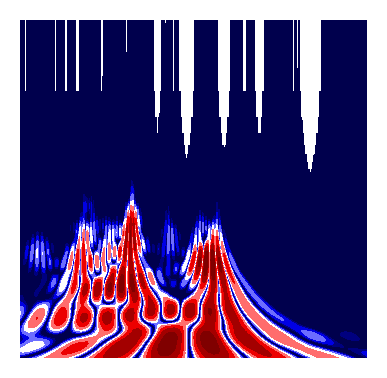

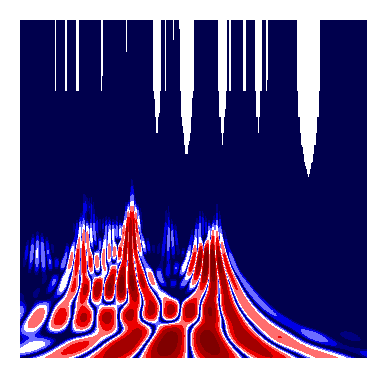

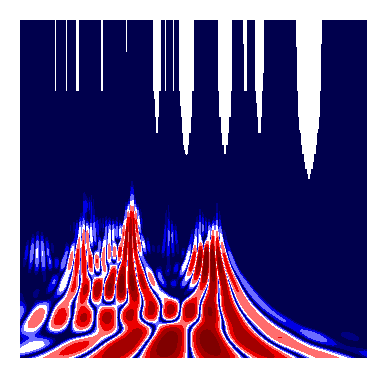

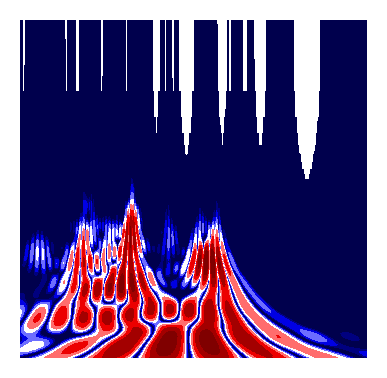

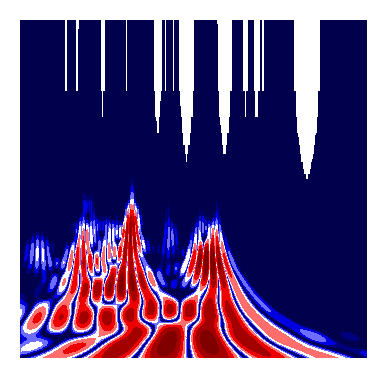

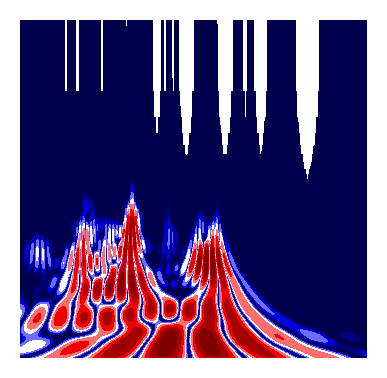

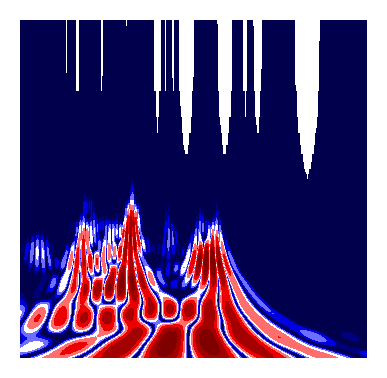

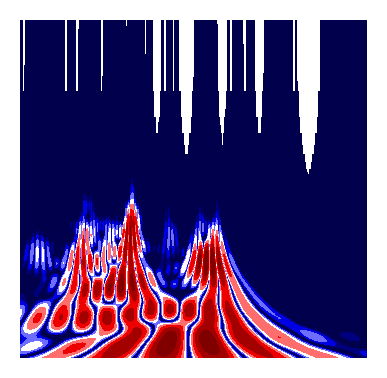

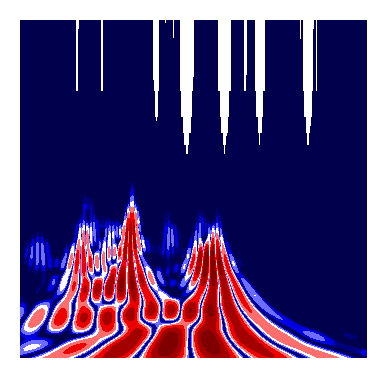

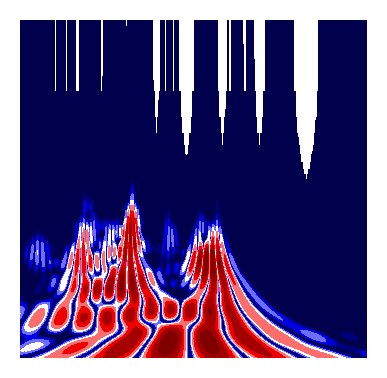

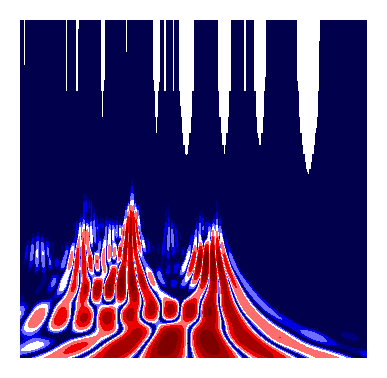

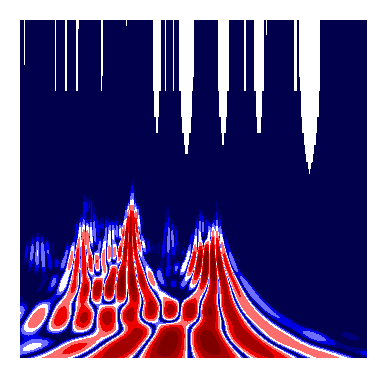

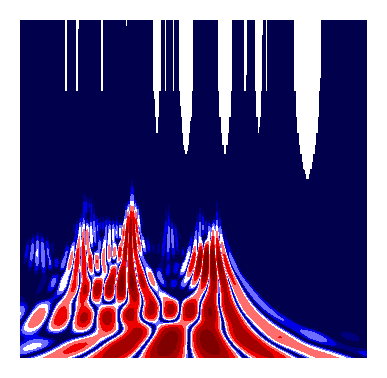

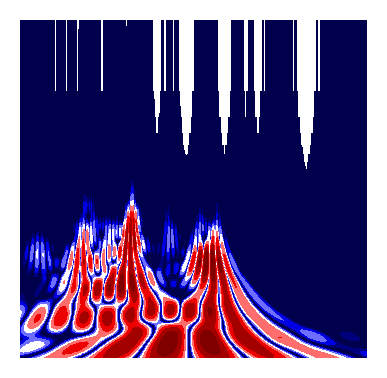

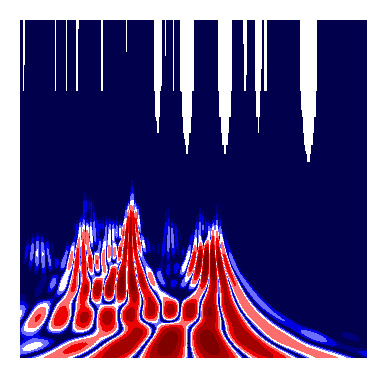

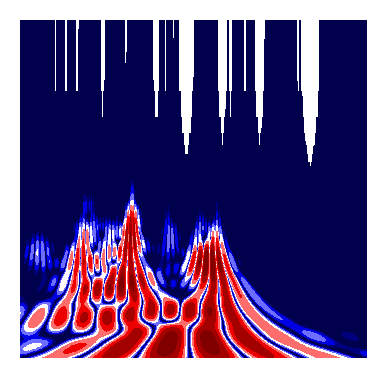

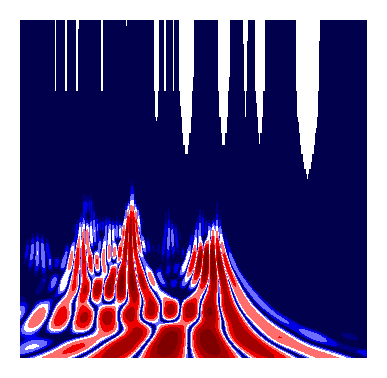

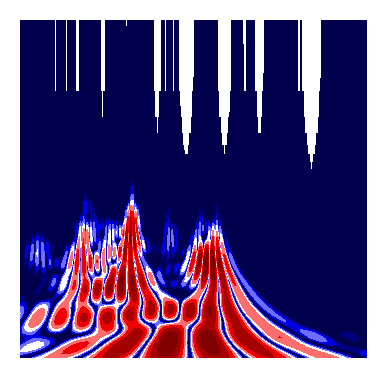

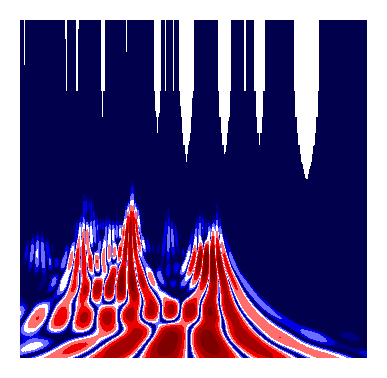

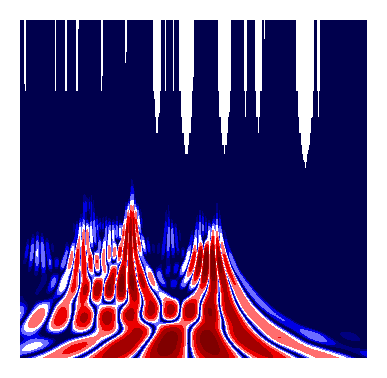

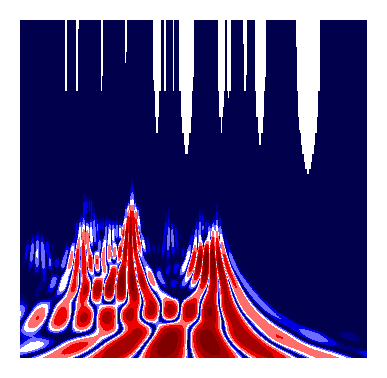

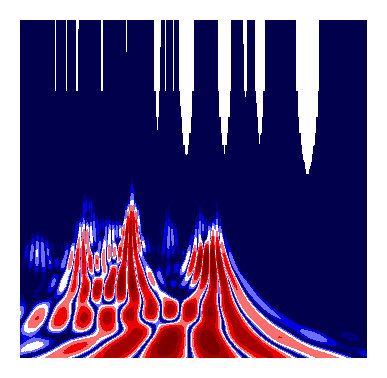

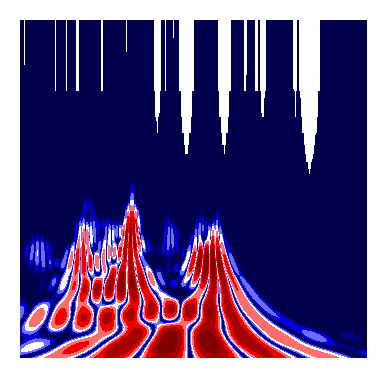

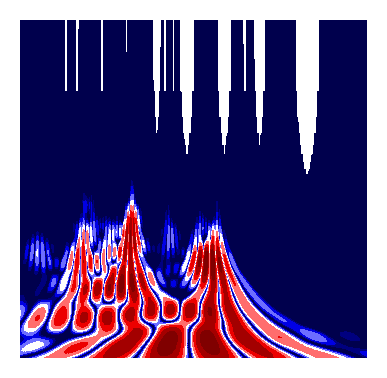

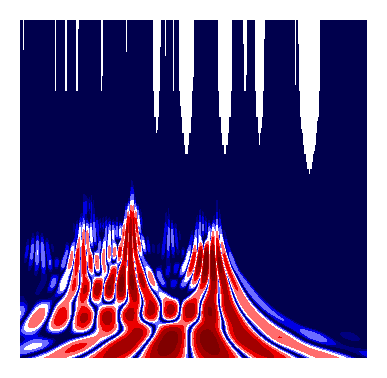

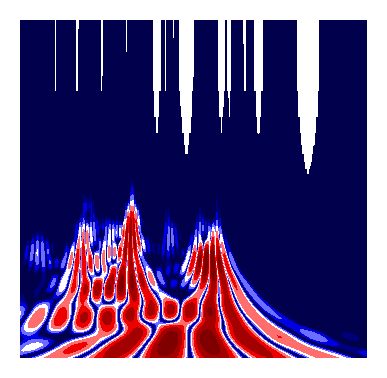

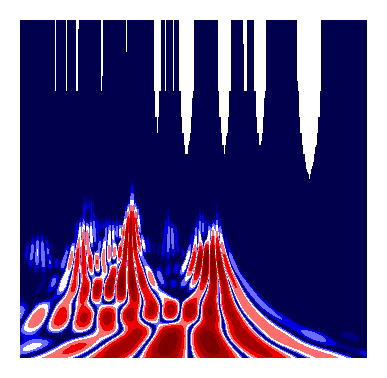

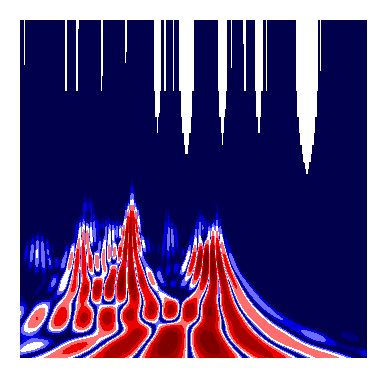

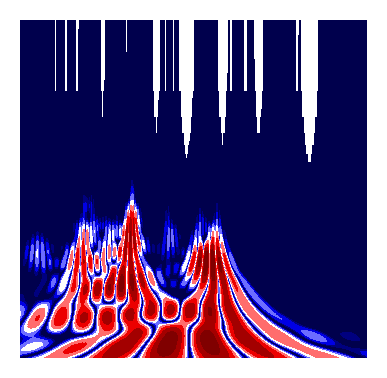

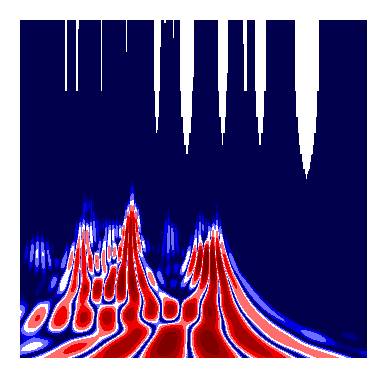

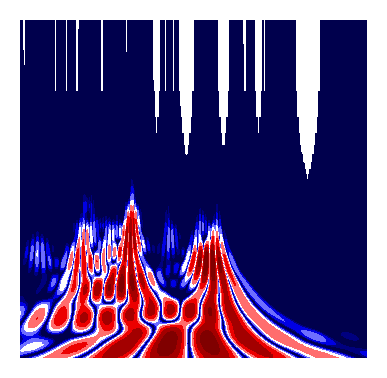

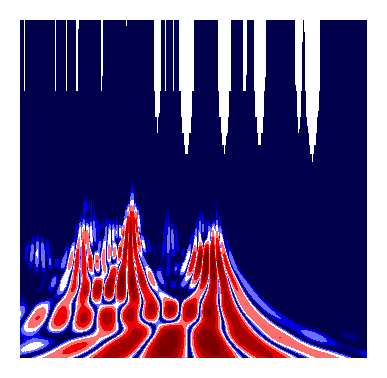

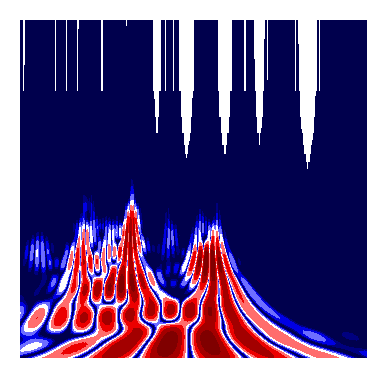

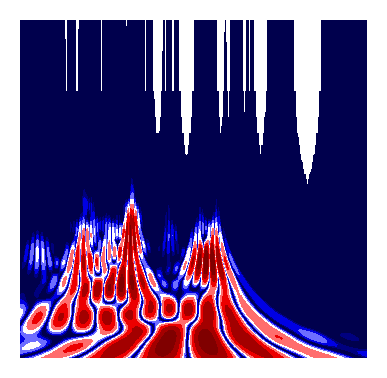

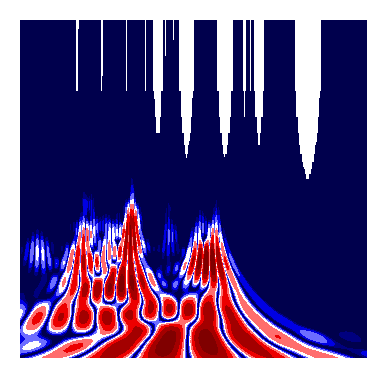

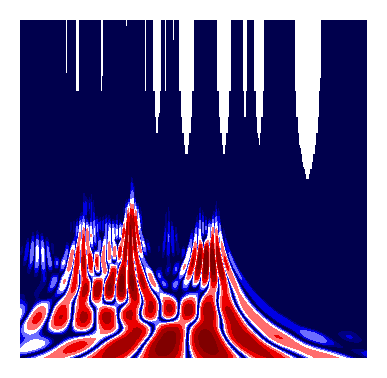

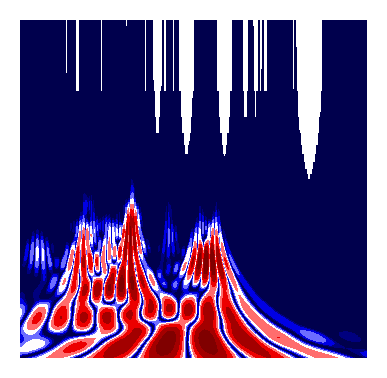

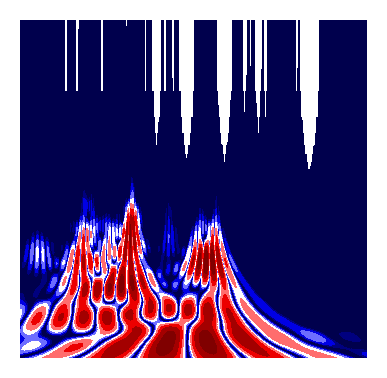

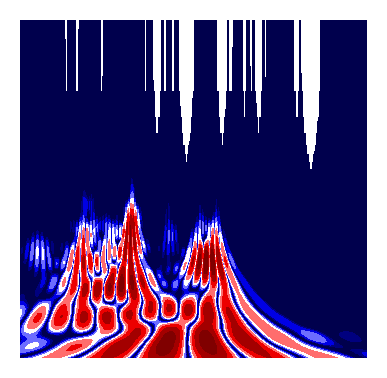

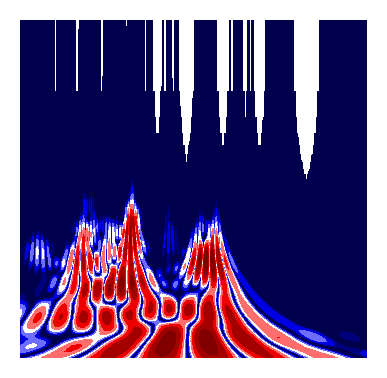

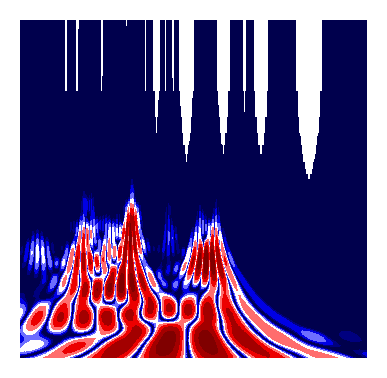

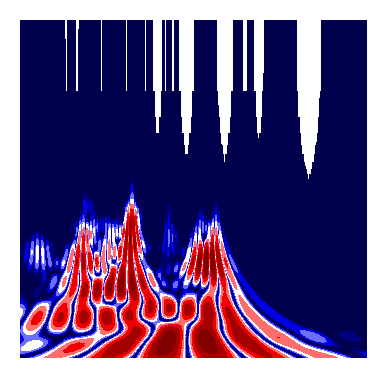

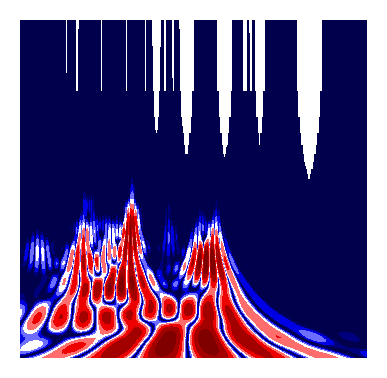

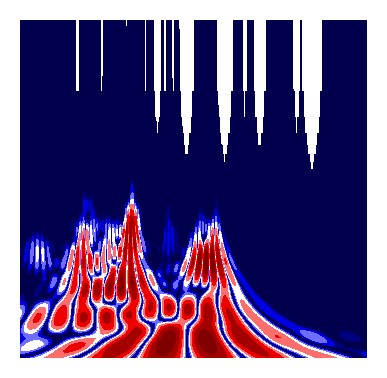

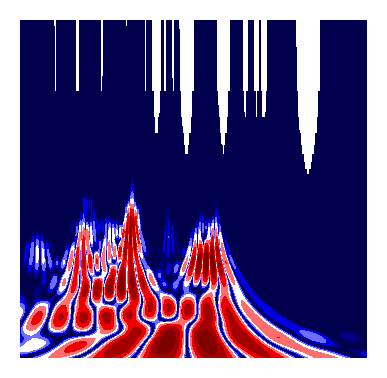

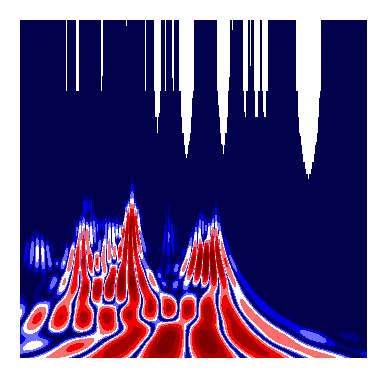

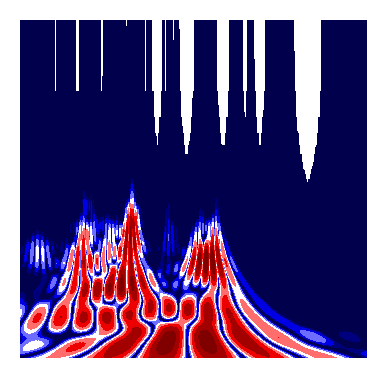

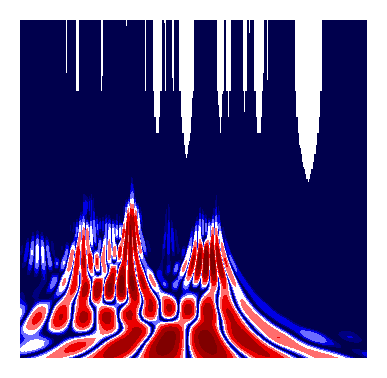

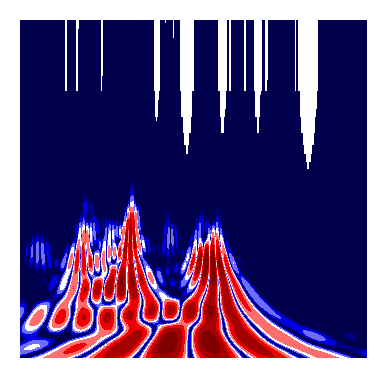

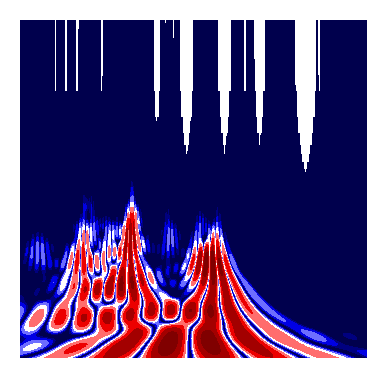

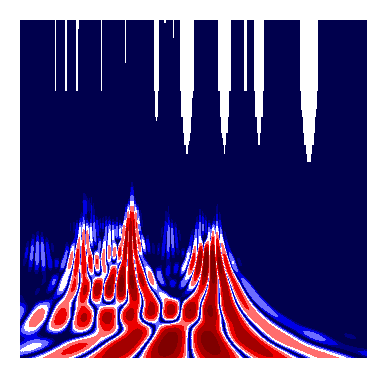

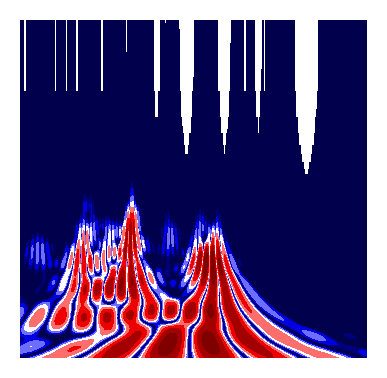

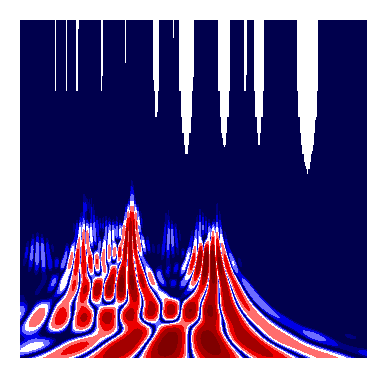

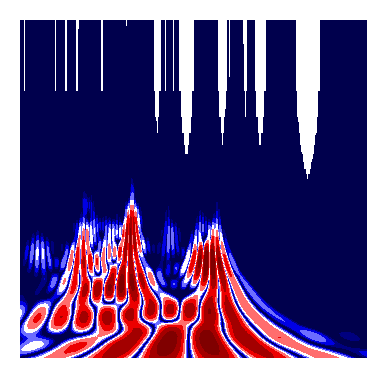

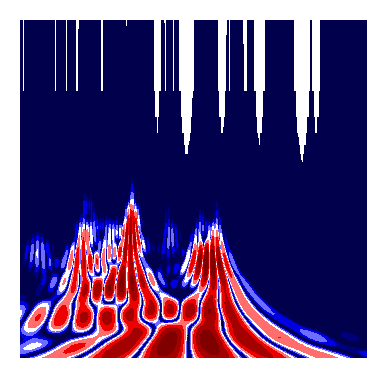

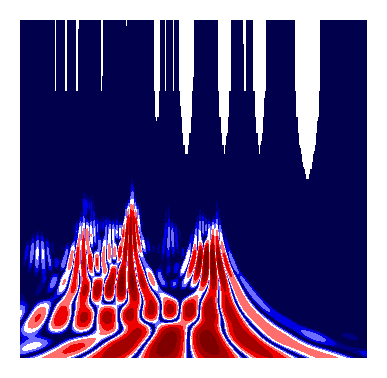

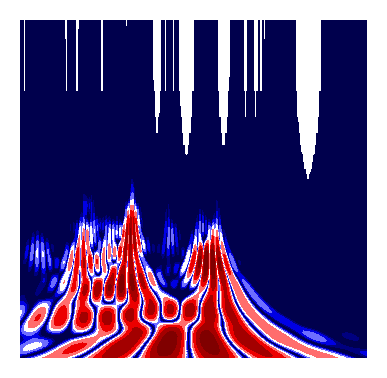

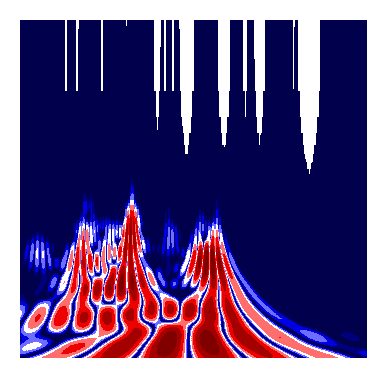

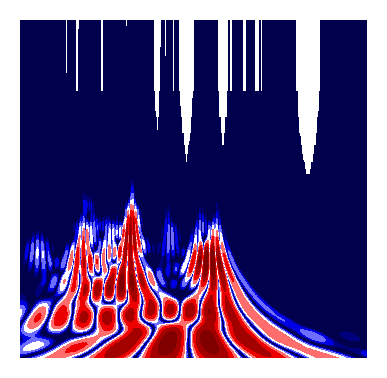

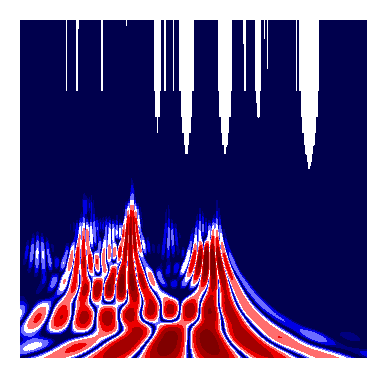

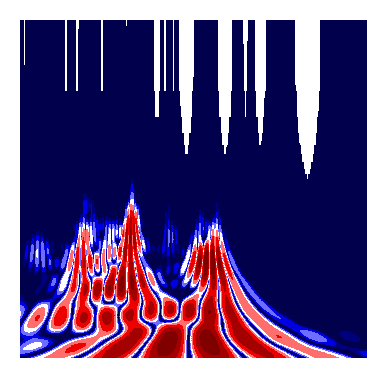

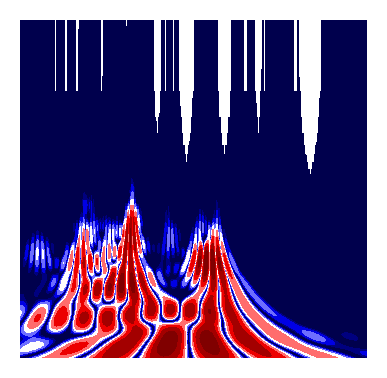

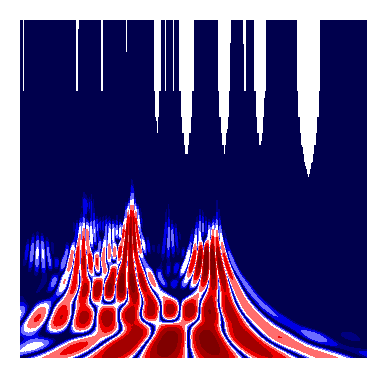

In [42]:
#df_train_label.columns =['Class']

ids = []
names = []

for row in df_train.itertuples():
    
    image_id = 'image' + str(row.Index)
    name = 'image' + str(row.Index) + '.png'

    ids.append(image_id)
    names.append(name)  
        
        
        
    filepath = train_path + name
        
    plot_wavelet(df_train.iloc[row.Index], filepath)
        
#df_train_label['Image_id'] = ids
#df_train_label['Name'] = names

   

C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\495793680.py:42: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\495793680.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=200)


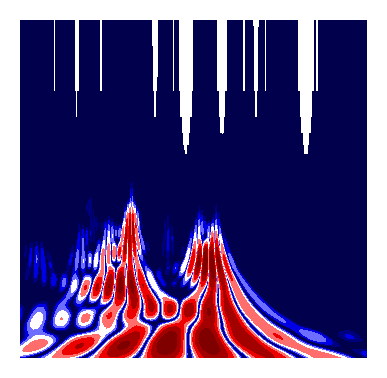

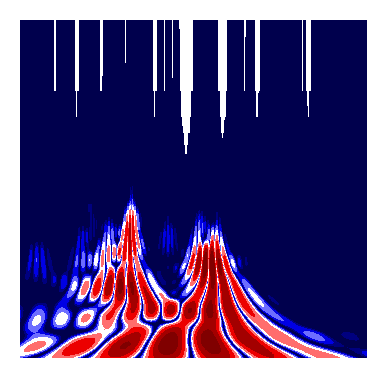

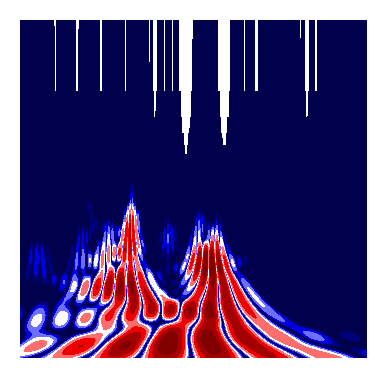

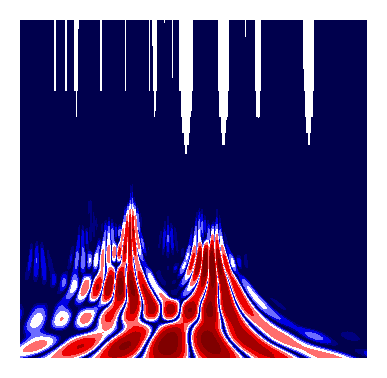

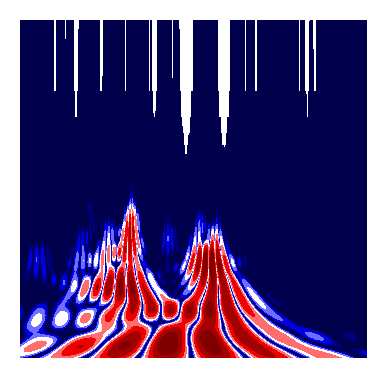

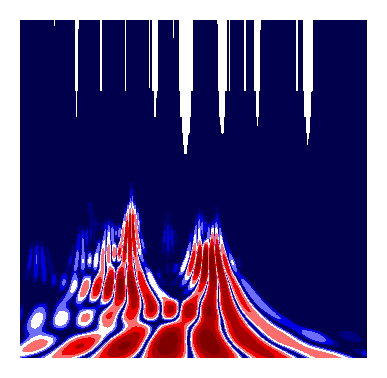

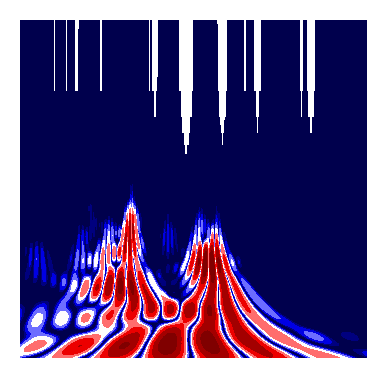

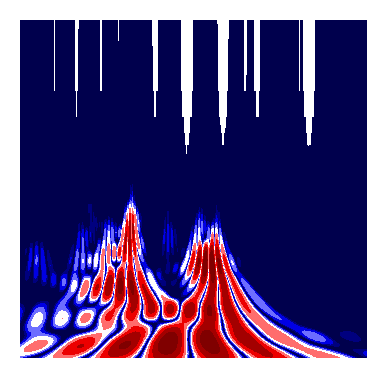

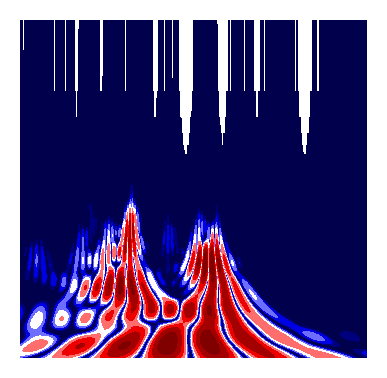

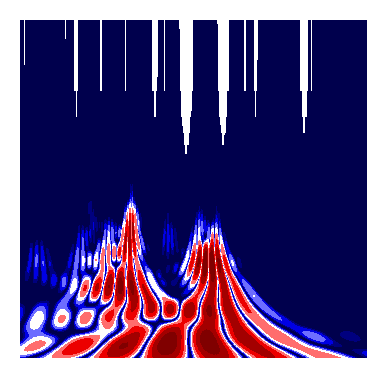

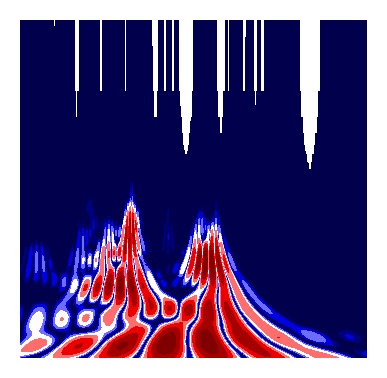

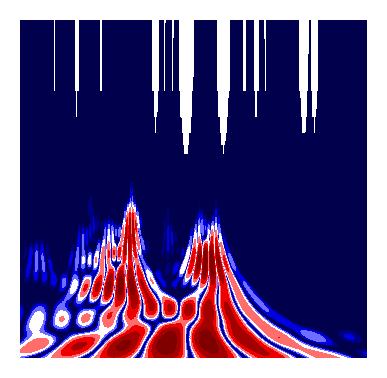

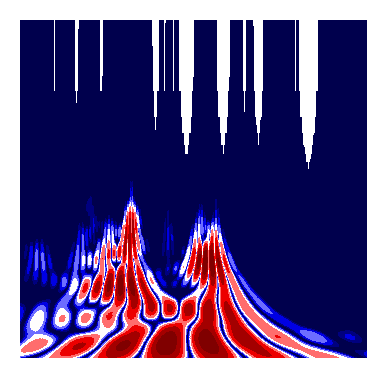

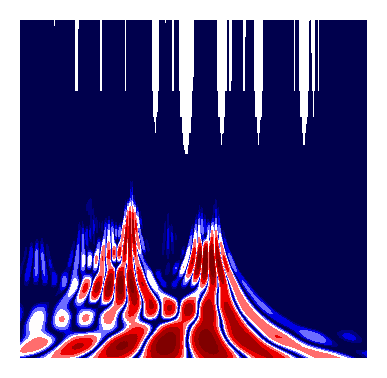

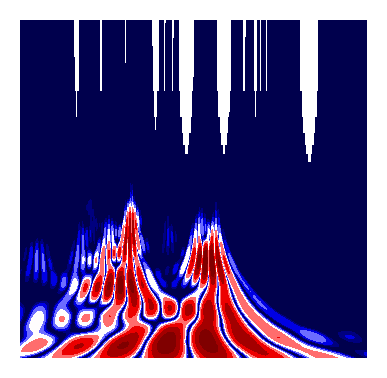

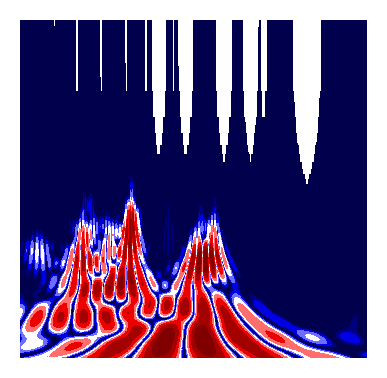

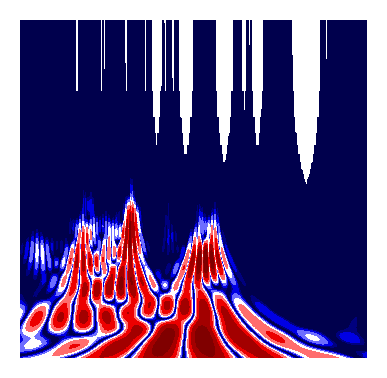

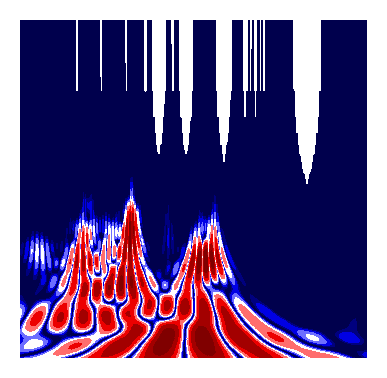

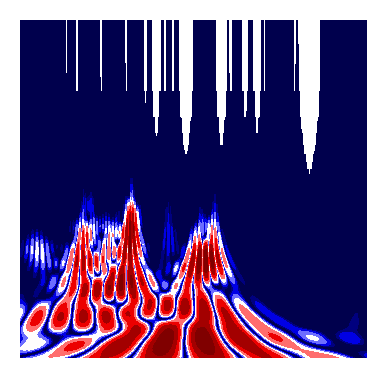

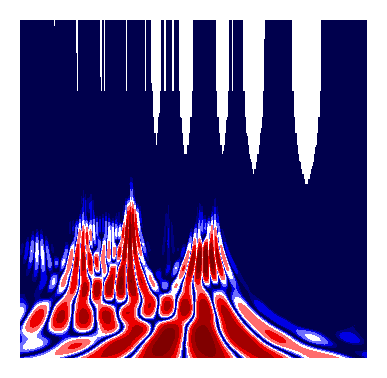

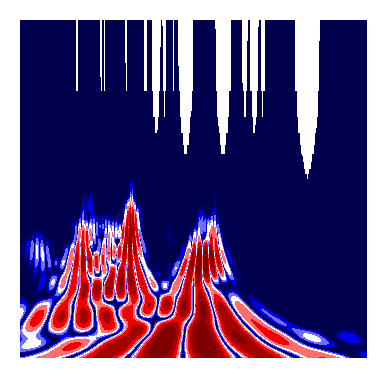

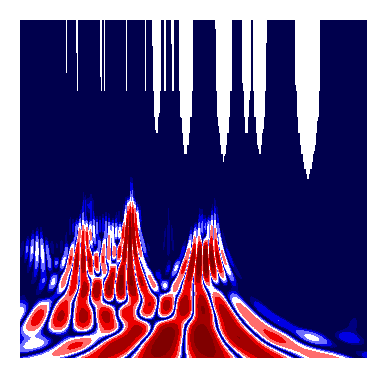

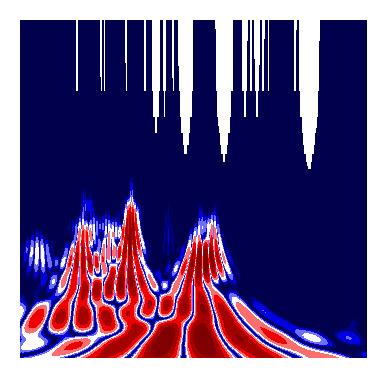

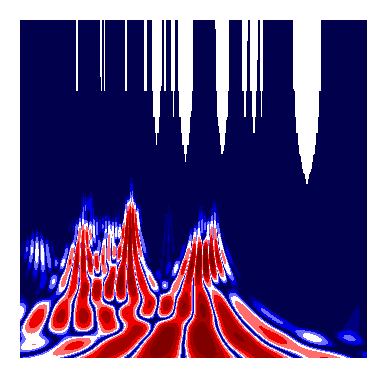

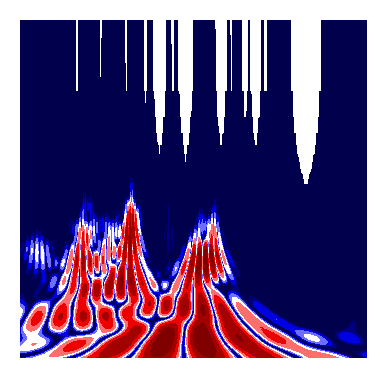

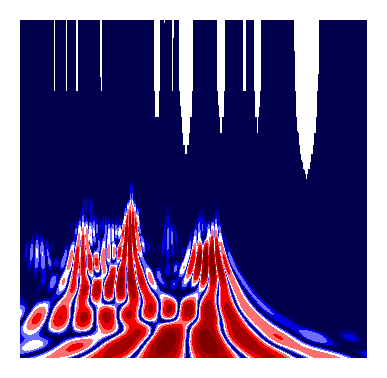

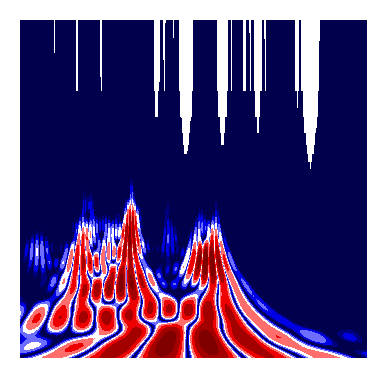

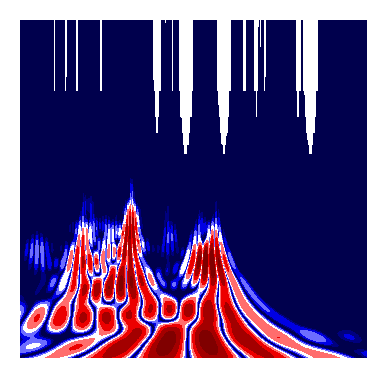

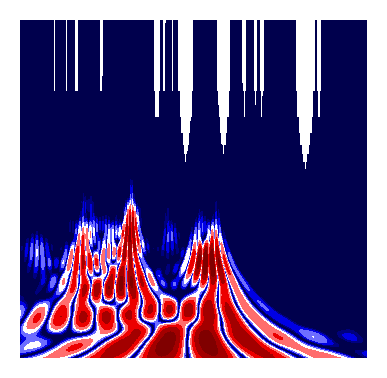

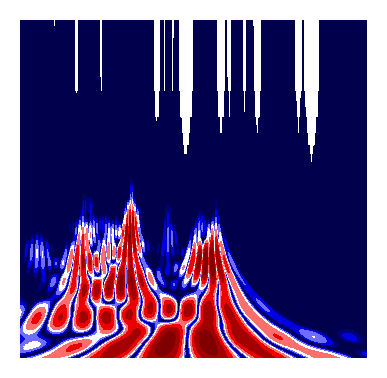

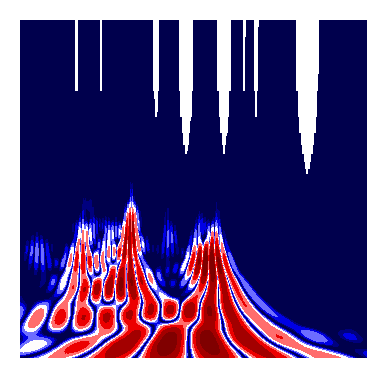

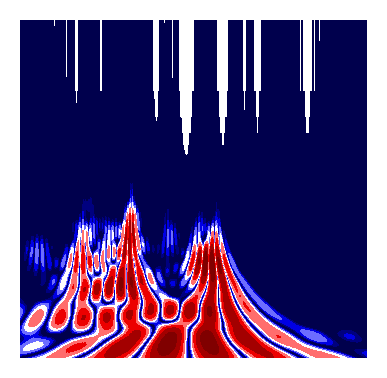

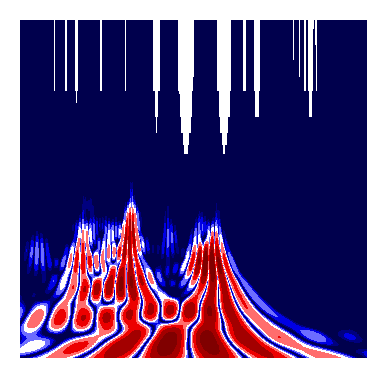

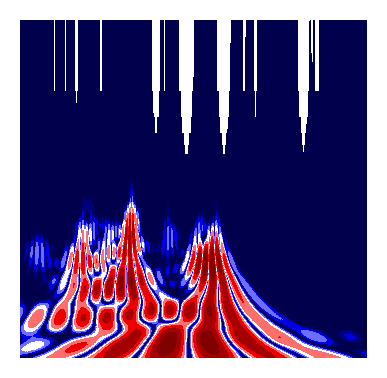

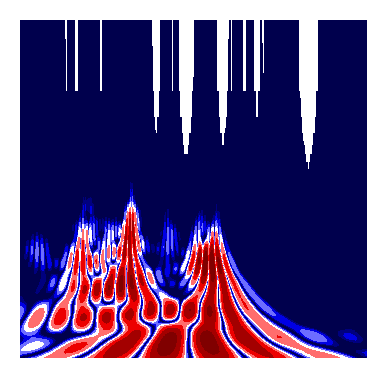

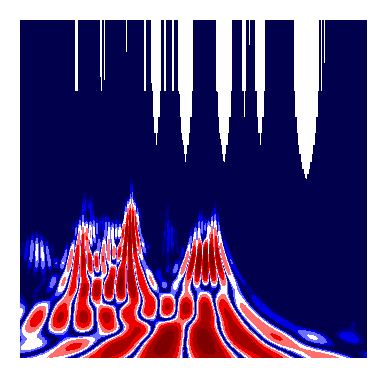

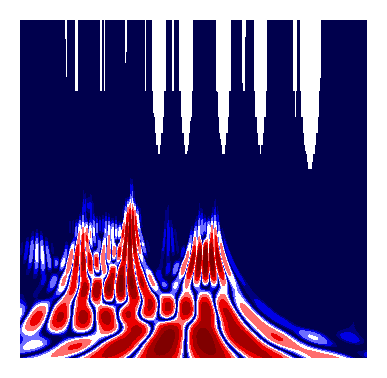

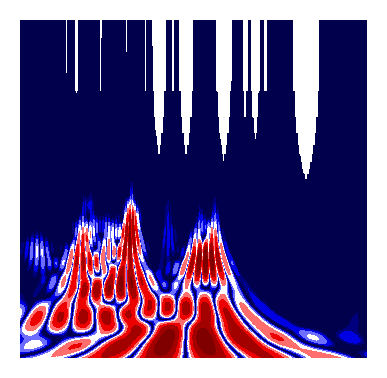

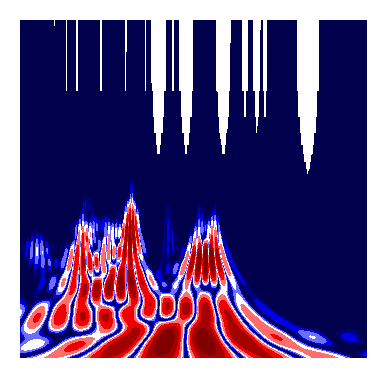

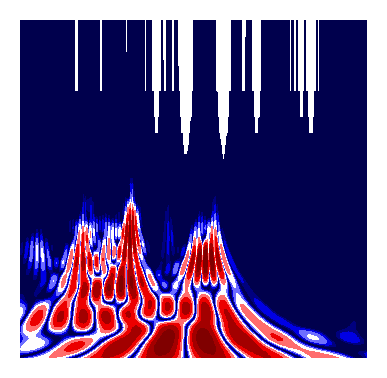

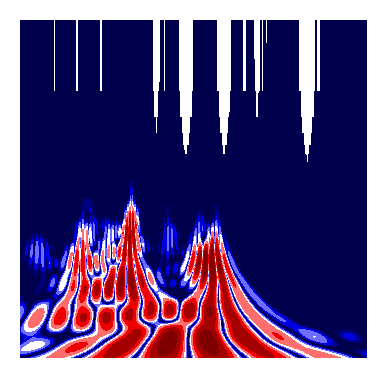

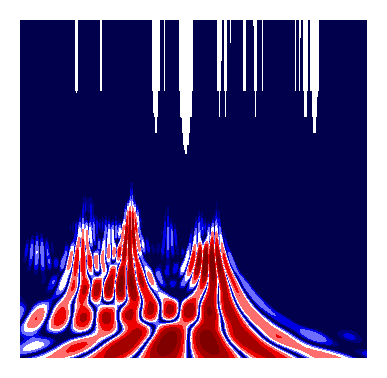

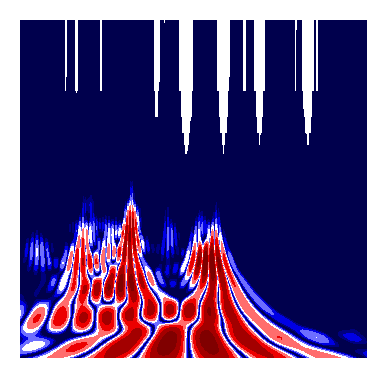

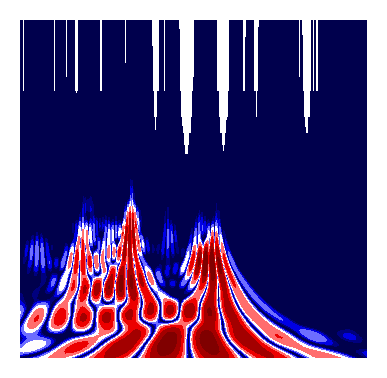

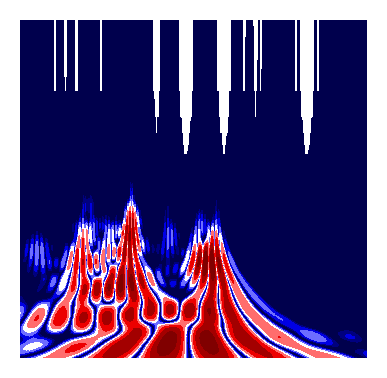

In [41]:
#df_validation_label.columns =['Class']
ids = []
names = []

for row in df_validation.itertuples():
    
    image_id = 'image' + str(row.Index)
    name = 'image' + str(row.Index) + '.png'

    ids.append(image_id)
    names.append(name)  
        
        
        
    filepath = validation_path + name
        
    plot_wavelet(df_validation.iloc[row.Index], filepath)
        
#df_validation_label['Image_id'] = ids
#df_validation_label['Name'] = names


In [ ]:
df_train_label.columns =['Class']
df_train_label = create_scalograms(df_train, df_train_label, train_path)

df_validation_label.columns =['Class']
df_validation_label = create_scalograms(df_validation, df_validation_label, validation_path)

df_test_label.columns =['Class']
df_test_label['Class'] = df_test_label['Class'].replace(['midgrade'],'mid-grade')
df_test_label = create_scalograms(df_test, df_test_label, test_path)

In [43]:
img_width = 347
img_height = 338

In [44]:
def extract_scalogram(path):
    height =  img_height# pixels in length
    width = img_width # pixels in width
  
    imgs = np.empty((0, height, width, 3)) 

    for filename in os.listdir(path):
        
        if filename.endswith(".png"):

            img = Image.open(os.path.join(path, filename)).convert('RGB')

            imgs = np.append(imgs, np.array(img).reshape((1, height, width, 3)), axis=0)
    
    return imgs


In [46]:
X_train = extract_scalogram(train_path)
X_validation = extract_scalogram(validation_path)
#X_test = extract_scalogram(test_path)

from sklearn import preprocessing

df_train_label['Class_int'] = pd.Categorical(df_train_label['Class']).codes
df_validation_label['Class_int'] = pd.Categorical(df_validation_label['Class']).codes
#df_test_label['Class_int'] = pd.Categorical(df_test_label['Class']).codes

y_train = df_train_label['Class_int']
y_validation = df_validation_label['Class_int']
#y_test = df_test_label['Class_int']

In [47]:
y_train=to_categorical(y_train)
y_validation=to_categorical(y_validation)
#y_test=to_categorical(y_test)

#Verifying the dimension after one hot encoding
print((X_train.shape,y_train.shape))
print((X_validation.shape,y_validation.shape))
#print((X_test.shape,y_test.shape))

((345, 338, 347, 3), (345, 3))
((45, 338, 347, 3), (45, 3))


In [48]:
def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1

In [49]:
#X_train = normalize_negative_one(X_train)
#X_validation = normalize_negative_one(X_validation)
#X_test = normalize_negative_one(X_test)

In [50]:
#Initializing the hyperparameters
batch_size= 16
epochs=10
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [51]:
#Image Data Augmentation -  technique of altering the existing data to create some more data for the model training proces

train_dategen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
train_generator = train_dategen.flow(X_train,  y_train, batch_size= batch_size)

validation_dategen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_generator = validation_dategen.flow(X_validation, y_validation, batch_size= batch_size)

test_generator = ImageDataGenerator(rescale = 1./255.)


In [52]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5) #change learning rATE  to get the best result

In [53]:
#Defining the googlenet model
#use resnet - try various versions of resnet
#compare googlenet to resnet and the other 4, to see which one is better. use the latest version of them

#base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (169,169,3))
# base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (169,169,3)) #
# base_model = ResNet101(include_top = False, weights = 'imagenet', input_shape = (169,169,3))
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (169,169,3))
# base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (169,169,3))
# base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (169,169,3))


#use resnet - try various versions of resnet
#compare googlenet to resnet and the other 4, to see which one is better. use the latest version of them

#changing the last layer
for layer in base_model.layers:
    layer.trainable = False
#https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

# #changing the last layer
# for layer in base_model.layers:
#   layer.trainable = False



83697664/83683744 [==============================] - 2s 0us/step


In [54]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________


In [55]:
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [56]:
model.fit_generator(train_generator, 
                    epochs = epochs, 
                    steps_per_epoch = X_train.shape[0]//batch_size, 
                    validation_data = validation_generator, 
                    validation_steps = X_validation.shape[0]//batch_size, callbacks=[lrr],  verbose = 1)

C:\Users\Razaq\AppData\Local\Temp\ipykernel_5792\1611713785.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/10
21/21 [==============================] - 36s 2s/step - loss: 1.1410 - accuracy: 0.3465 - val_loss: 1.0981 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - 32s 2s/step - loss: 1.1442 - accuracy: 0.3155 - val_loss: 1.0893 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - 32s 1s/step - loss: 1.1385 - accuracy: 0.3587 - val_loss: 1.1077 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - 32s 1s/step - loss: 1.1809 - accuracy: 0.3222 - val_loss: 1.1909 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 5/10
21/21 [==============================] - 32s 1s/step - loss: 1.1498 - accuracy: 0.3404 - val_loss: 1.1161 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/10
21/21 [==============================] - 32s 2s/step - loss: 1.1865 - accuracy: 0.3131 - val_loss: 1.0974 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 7/10
21/21 [==============================] - 31s 1s/step - loss: 1.1470 - a

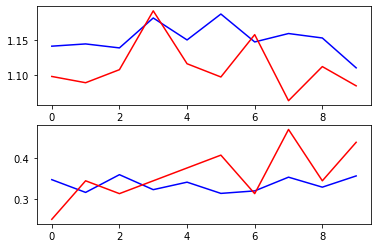

In [57]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test,axis=1)

In [ ]:
print(y_pred) #predict what class the test